In [1]:
## last gen 
from scipy.stats import spearmanr, pearsonr, kendalltau

import pandas as pd
import pickle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#import allel
#vcf = allel.read_vcf('../key_files/greneNet_final_v1.1_LDpruned.recode.vcf')
#ecotypes_names = vcf['samples']

In [3]:
#pd.Series(ecotypes_names).to_csv('../key_files/founder_ecotype_names.csv', index=None)

In [4]:
ecotypes_names = pd.read_csv('../key_files/founder_ecotype_names.csv')['0'].to_list()

In [47]:
clim_sites_during_exp = pd.read_csv('../key_files/bioclimvars_sites_era5_year_2018.csv')
#sites_test = pd.Series(test).str.split('_').str[0].astype(int)

In [6]:
#unique_sites = pd.read_csv('../key_files/final_gen.csv')['site'].unique()

In [7]:
first_gen = pd.read_csv('../key_files/generation_1_sample_names.txt',header=None)[0]
samples = first_gen.to_list()

In [8]:
unique_sites = first_gen.str.split('_').str[0].unique()

In [46]:
unique_sites

array(['1', '2', '4', '5', '6', '9', '10', '11', '12', '13', '23', '24',
       '25', '26', '27', '28', '32', '33', '37', '42', '43', '45', '46',
       '48', '49', '52', '53', '54', '55', '57', '60'], dtype=object)

In [49]:
#sort_bio1 = clim_sites_during_exp
clim_sites_during_exp_s = clim_sites_during_exp[clim_sites_during_exp['site'].isin(unique_sites.astype(int))]

sort_bio1 = clim_sites_during_exp_s[['site', 'bio1']].sort_values('bio1')['site'].astype(str).values

In [50]:
sort_bio1_int = clim_sites_during_exp_s[['site', 'bio1']].sort_values('bio1')['site'].values

In [51]:
sort_bio1_int

array([24, 27, 37, 23, 48, 42,  1, 55, 46, 25, 49, 33, 52, 57, 53, 54,  9,
       12, 11,  6,  5,  2, 45, 28,  4, 32, 43, 60, 13, 10, 26])

In [170]:
delta_ef=pd.read_csv('../key_files/delta_ecotype_freq.txt', sep = '\t', usecols = samples)#[['log_p1_p0','ecotype', 'site','plot']]
ef=pd.read_csv('../key_files/merged_ecotype_frequency.txt', sep = '\t', usecols = samples)#[['log_p1_p0','ecotype', 'site','plot']]
delta_ef.index = ecotypes_names
ef.index = ecotypes_names

In [171]:
founder_ef = pd.read_csv('../key_files/founder_ecotype_frequency.txt', header=None, sep = '\t')

In [172]:
founder_ef.columns = ['ecotype', 'intial_freq']

In [173]:
founder_ef = founder_ef.set_index('ecotype')

In [174]:
(founder_ef.index == ef.index).all()

True

In [178]:
## P1/P0 ECOTYPE FREQ
p1_p0 = {}
for i in ef.columns:
    ## add small number so log is noti ndet
    p1_p0[i] = np.log((ef[i] + 0.0001) / founder_ef['intial_freq'])

In [179]:
p1_p0 = pd.DataFrame(p1_p0)

In [180]:
file_path = '../jacknife_first_gen/splits_samples_first_gen.pkl'
# splits_samples_last_gen_no33.pkl
# Open and load the .pkl file
with open(file_path, 'rb') as file:
    samples = pickle.load(file)

In [14]:
len(samples)

31

In [15]:
## recalculate GO

In [16]:
genotype_counts = pd.read_csv('../leave_1_out/genotype_counts_fullgenome231ecotypes.csv').drop('Unnamed: 0', axis=1)

In [17]:
snp_dict = pd.read_csv('../key_files/var_pos_grenenet.csv')

In [19]:
split = 30

In [20]:
pd.read_csv(f'results/split_{split}/binomial_reg_results_last_gen.csv')

60     slope        pvalue  intercept      snp_id
0        0.268391 -0.007306  5.268781e-01  -0.992984       1_346
1        0.085484  0.082684  1.682599e-05  -2.481144       1_353
2        0.095081 -0.020173  2.433327e-01  -2.226013       1_363
3        0.134850  0.381686  3.836123e-96  -2.371506       1_395
4        0.134850  0.381686  3.836123e-96  -2.371506       1_396
...           ...       ...           ...        ...         ...
1054569  0.752160 -0.212829  4.715695e-61   1.396084  5_26975078
1054570  0.085198  0.058191  2.168549e-03  -2.451909  5_26975121
1054571  0.085198  0.058191  2.168549e-03  -2.451909  5_26975148
1054572  0.466469  0.008957  3.837454e-01  -0.146360  5_26975272
1054573  0.159979 -0.064097  2.411163e-06  -1.572272  5_26975288

[1054574 rows x 5 columns]

In [49]:
go_per_site = {}
for split in range(len(samples)):
    print(split)
    br_results = pd.read_csv(f'results/split_{split}/binomial_reg_results_last_gen.csv')
    #br_results = br_results[br_results['pvalue'] < 0.05/len(br_results)]
    #br_results = br_results[br_results['pvalue'] < br_results['pvalue'].quantile(0.25)]
    br_results = br_results.reset_index(drop=True)

    mask_full_genotype = snp_dict['id'].isin(br_results['snp_id'])
    
    genotype_counts_red = genotype_counts.loc[mask_full_genotype,:]
    
    genotype_counts_red = genotype_counts_red.reset_index(drop=True)
    genotype_counts_red = genotype_counts_red.replace({2: 1, 1: 0.5, 0: 0})
    
    site_predicted = br_results.columns[0]
    print(site_predicted)
    site_predict_proba = br_results[site_predicted]

    ## for each site, subrstract the actual value by the probability fo getting a success 
    genotype_counts_subs = genotype_counts_red.sub(site_predict_proba, axis=0)
    genotype_counts_subs = genotype_counts_subs**2
    ## ge tthe absolute value 
    
    ## sum over ecotypes 
    go = (genotype_counts_subs.sum(axis=0)) / len(genotype_counts_subs)
    go_per_site[site_predicted] = go

0
1
1
2
2
4
3
5
4
6
5
9
6
10
7
11
8
12
9
13
10
23
11
24
12
25
13
26
14
27
15
28
16
32
17
33
18
37
19
42
20
43
21
45
22
46
23
48
24
49
25
52
26
53
27
54
28
55
29
57
30
60


In [50]:
go_per_site_df = pd.DataFrame(go_per_site)

go_per_site_df.index = go_per_site_df.index.astype(int)

In [51]:
go_per_site_df.index = ecotypes_names

In [79]:
go_per_site_df.to_csv('genomic_offset_per_site_firt_gen_prob_squared_l1out_all_proba.csv',index=None)

In [80]:
go_per_site_df.columns

Index(['1', '2', '4', '5', '6', '9', '10', '11', '12', '13', '23', '24', '25',
       '26', '27', '28', '32', '33', '37', '42', '43', '45', '46', '48', '49',
       '52', '53', '54', '55', '57', '60'],
      dtype='object')

In [81]:
# genomic_offset_per_site_last_gen_prob_squared_l1out
# combined_results_onlysign_p_top_ecotypes.csv

In [82]:
## start here

In [181]:
go_per_site_df = pd.read_csv('genomic_offset_per_site_firt_gen_prob_squared_l1out_all_proba.csv')

In [182]:
go_per_site_df.index = ecotypes_names

In [183]:
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [184]:
results_mean = {}
for site in unique_sites:
    if site != 33:
        ## one site 
        ## retreive ecotype frequecnies 
        ef1 = p1_p0[[col for col in p1_p0.columns if col.startswith(f'{site}_')]]
        ef_mean = ef1.mean(axis=1)
        ef_mean.name = 'mean'
        cd = go_per_site_df[str(site)]
        
        conc = pd.concat([ef_mean, cd],axis=1)
        #conc = conc.sort_values('mean')
        ## becasue some ecotpyes are nan 
        conc = conc.replace([np.inf, -np.inf], np.nan).dropna()
        X_ranked = conc['mean']
        y_ranked = conc[str(site)]

        sp_correlation, _ = spearmanr(X_ranked, y_ranked)
        pearsonr_value = pearsonr(X_ranked, y_ranked)[0]
        kendall_tau, _ = kendalltau(X_ranked, y_ranked)

        X = conc[str(site)].values.reshape(-1, 1)  # Independent variable
        y = conc['mean'].values # Dependent variable

        # Fit the linear model
        model = LinearRegression().fit(X, y)
        # Predict the valu.es
        y_pred = model.predict(X)
        
        r_squared = r2_score(y, y_pred)

        res_list = [sp_correlation, pearsonr_value, r_squared, kendall_tau]
        for i in [10,20,30,40,50]:
            ## tail on ecotypes because the largest go on bottom and head for go because the smalles go teh better/
            top_10_observed_indices =  conc['mean'].sort_values().tail(i).index
            top_10_predicted_indices = conc[str(site)].sort_values().head(i).index
    
            # Compare top 10 indices
            common_top_indices = len(set(top_10_observed_indices).intersection(set(top_10_predicted_indices)))
    
            # Calculate the percentage of common top 10 indices
            top_10_match_percentage = (common_top_indices / i) * 100
            res_list.append(top_10_match_percentage)
        results_mean[str(site)] = res_list

In [185]:
results_mean = pd.DataFrame(results_mean).T

results_mean.columns = ['sp_correlation', 'pearsonr', 'r_squared','kendall_tau', 'top_10','top_20','top_30','top_40','top_50']

results_mean['sp_correlation'] = results_mean['sp_correlation'] * -1

results_mean['pearsonr'] = results_mean['pearsonr']  * -1
results_mean['kendall_tau'] = results_mean['kendall_tau']  * -1

results_mean = results_mean.reset_index()

results_mean = results_mean.rename(columns = {'index':'site'})

In [186]:
results = {}
for site in unique_sites:
    if site != 33:
        ## one site 
        ## retreive ecotype frequecnies 
        ef1 = p1_p0[[col for col in p1_p0.columns if col.startswith(f'{site}_')]]
        cd = go_per_site_df[str(site)]
        
        for sample in ef1.columns:
            ef_f = ef1[sample]
            conc = pd.concat([ef_f, cd],axis=1)
            conc = conc.sort_values(sample)
            ## becasue some ecotpyes are nan 
            conc = conc.replace([np.inf, -np.inf], np.nan).dropna()
            X_ranked = conc[sample]
            y_ranked = conc[str(site)]
    
            sp_correlation, _ = spearmanr(X_ranked, y_ranked)
            pearsonr_value = pearsonr(X_ranked, y_ranked)[0]
            kendall_tau, _ = kendalltau(X_ranked, y_ranked)

            X = conc[str(site)].values.reshape(-1, 1)  # Independent variable
            y = conc[sample].values # Dependent variable
    
            # Fit the linear model
            model = LinearRegression().fit(X, y)
            # Predict the valu.es
            y_pred = model.predict(X)
            
            r_squared = r2_score(y, y_pred)
    
            res_list = [sp_correlation, pearsonr_value, r_squared, kendall_tau]
    
            for i in [10,20,30,40,50, 60, 100]:
                top_10_observed_indices = conc[sample].sort_values().tail(i).index
                top_10_predicted_indices = conc[str(site)].sort_values().head(i).index
        
                # Compare top 10 indices
                common_top_indices = len(set(top_10_observed_indices).intersection(set(top_10_predicted_indices)))
        
                # Calculate the percentage of common top 10 indices
                top_10_match_percentage = (common_top_indices / i) * 100
                res_list.append(top_10_match_percentage)
            results[sample] = res_list

In [187]:
results = pd.DataFrame(results).T

results.columns = ['sp_correlation', 'pearsonr', 'r_squared','kendall_tau', 'top_10','top_20','top_30','top_40','top_50', 'top_60', 'top_100']

results['sp_correlation'] = results['sp_correlation'] *-1

results['pearsonr'] = results['pearsonr']  *-1
results['kendall_tau'] = results['kendall_tau']  *-1
results = results.reset_index()

results['site'] = results['index'].str.split('_').str[0]

results['plot'] = results['index'].str.split('_').str[2]

In [188]:
results = results[results['site']!='33']

In [189]:
results['site'].nunique()

30

In [190]:
results.columns = ['sample', 'sp_correlation', 'pearsonr', 'r_squared', 'kendall_tau',
       'top_10', 'top_20', 'top_30', 'top_40', 'top_50', 'top_60', 'top_100',
       'site', 'plot']

In [133]:
#results.to_csv('genomic_offset_firstgen_binom_reg_p1_p0_results.csv')

In [191]:
results.to_csv('genomic_offset_firstgen_binom_reg_log_p1_p0_results.csv')

In [ ]:
## sumarry 

In [11]:
log_p1p0 = pd.read_csv('genomic_offset_firstgen_binom_reg_log_p1_p0_results.csv')

p1p0 = pd.read_csv('genomic_offset_firstgen_binom_reg_p1_p0_results.csv')

ef_raw = pd.read_csv('genomic_offset_firstgen_binom_reg_results.csv')

In [12]:
results = p1p0.copy()

In [193]:
ef_raw

Unnamed: 0   sample  sp_correlation  pearsonr  r_squared  kendall_tau  \
0             0    1_1_1        0.225129  0.127150   0.016167     0.156559   
1             1    1_1_2        0.323221  0.214506   0.046013     0.218370   
2             2    1_1_3        0.401997  0.206983   0.042842     0.280030   
3             3    1_1_4        0.413692  0.132567   0.017574     0.286204   
4             4    1_1_5        0.374171  0.165260   0.027311     0.241709   
..          ...      ...             ...       ...        ...          ...   
320         321   60_1_8        0.666610  0.168056   0.028243     0.489589   
321         322   60_1_9        0.231119  0.005560   0.000031     0.163012   
322         323  60_1_10        0.316288 -0.035822   0.001283     0.231722   
323         324  60_1_11        0.495393  0.047556   0.002262     0.372151   
324         325  60_1_12        0.303231  0.054878   0.003012     0.211283   

     top_10  top_20     top_30  top_40  top_50     top_60  top_100  site  plot  
0       0.0    15.0  23.333333    35.0    34.0  36.666667     52.0     1     1  
1      20.0    20.0  16.666667    17.5    26.0  36.666667     53.0     1     2  
2       0.0    15.0  20.000000    25.0    24.0  35.000000     58.0     1     3  
3      10.0    10.0  16.666667    25.0    30.0  33.333333     57.0     1     4  
4      10.0    10.0  26.666667    20.0    24.0  35.000000     57.0     1     5  
..      ...     ...        ...     ...     ...        ...      ...   ...   ...  
320     0.0    25.0  33.333333    35.0    34.0  38.333333     68.0    60     8  
321     0.0     0.0   3.333333    17.5    26.0  31.666667     56.0    60     9  
322    10.0     5.0  13.333333    15.0    24.0  28.333333     50.0    60    10  
323     0.0    30.0  30.000000    35.0    40.0  38.333333     61.0    60    11  
324     0.0    20.0  23.333333    32.5    36.0  36.666667     52.0    60    12  

[325 rows x 15 columns]

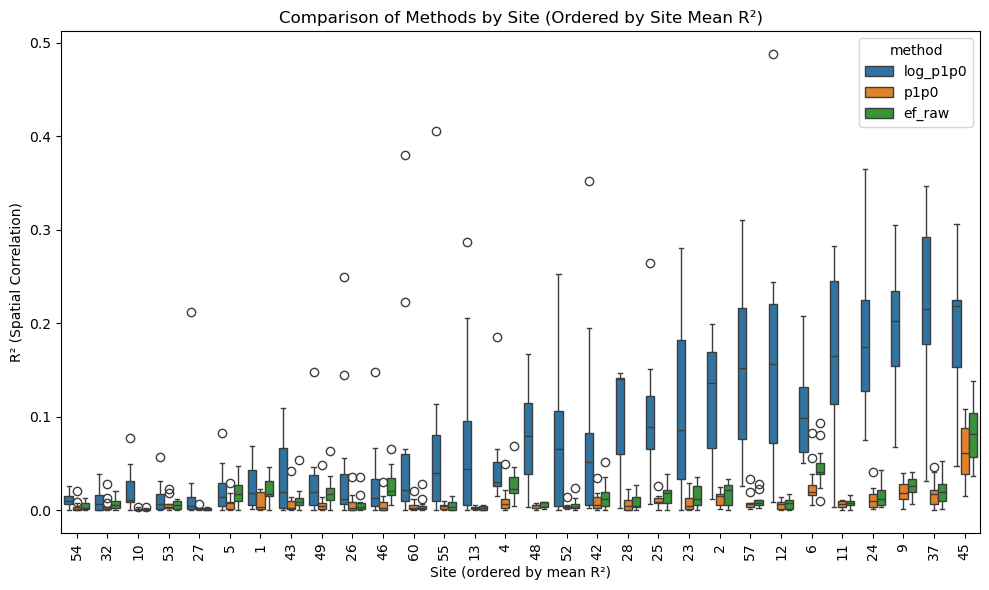

r_squared statistics per Method (All Sites Combined):
              mean           min       max
method                                    
ef_raw    0.016375  3.185637e-09  0.137933
log_p1p0  0.086108  1.028929e-07  0.487637
p1p0      0.010350  9.485761e-10  0.108667


In [194]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Compute mean r_squared per site (across all methods)
site_order = combined_df.groupby('site')['r_squared'].mean().sort_values().index.tolist()

# Step 2: Plot with ordered x-axis
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='site', y='r_squared', hue='method', order=site_order)

# Formatting
plt.xticks(rotation=90)
plt.xlabel("Site (ordered by mean R²)")
plt.ylabel("R² (Spatial Correlation)")
plt.title("Comparison of Methods by Site (Ordered by Site Mean R²)")
plt.tight_layout()
plt.show()



# Compute mean, min, and max r_squared per method
r_squared_stats = combined_df.groupby('method')['r_squared'].agg(['mean', 'min', 'max'])
# Print the summary
print("r_squared statistics per Method (All Sites Combined):")
print(r_squared_stats)

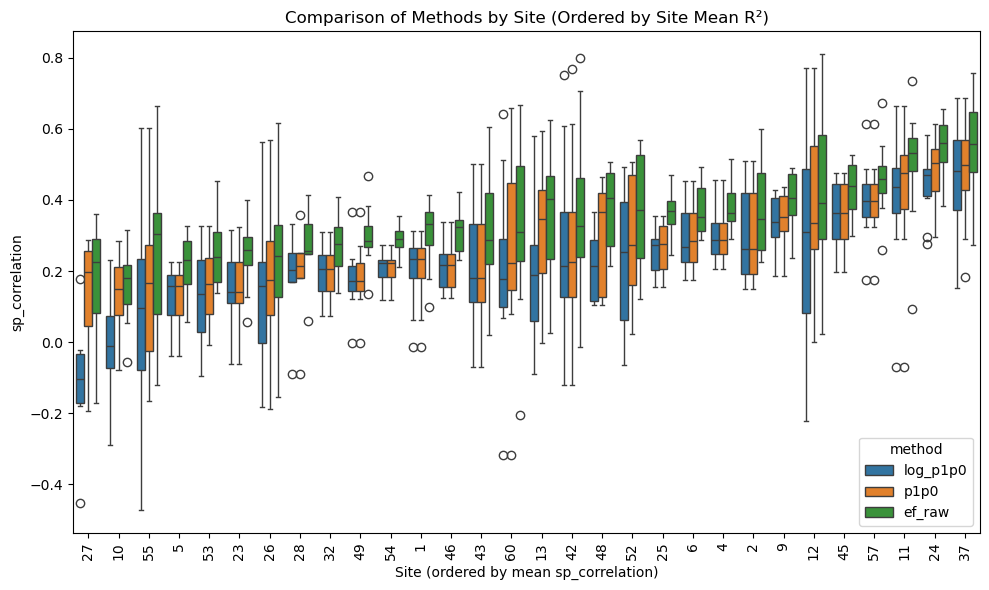

sp_correlation statistics per Method (All Sites Combined):
              mean       min       max
method                                
ef_raw    0.340100 -0.205868  0.809914
log_p1p0  0.230492 -0.471914  0.771897
p1p0      0.263255 -0.316052  0.771897


In [195]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Compute mean r_squared per site (across all methods)
site_order = combined_df.groupby('site')['sp_correlation'].mean().sort_values().index.tolist()

# Step 2: Plot with ordered x-axis
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='site', y='sp_correlation', hue='method', order=site_order)

# Formatting
plt.xticks(rotation=90)
plt.xlabel("Site (ordered by mean sp_correlation)")
plt.ylabel("sp_correlation")
plt.title("Comparison of Methods by Site (Ordered by Site Mean R²)")
plt.tight_layout()
plt.show()



# Compute mean, min, and max r_squared per method
r_squared_stats = combined_df.groupby('method')['sp_correlation'].agg(['mean', 'min', 'max'])
# Print the summary
print("sp_correlation statistics per Method (All Sites Combined):")
print(r_squared_stats)

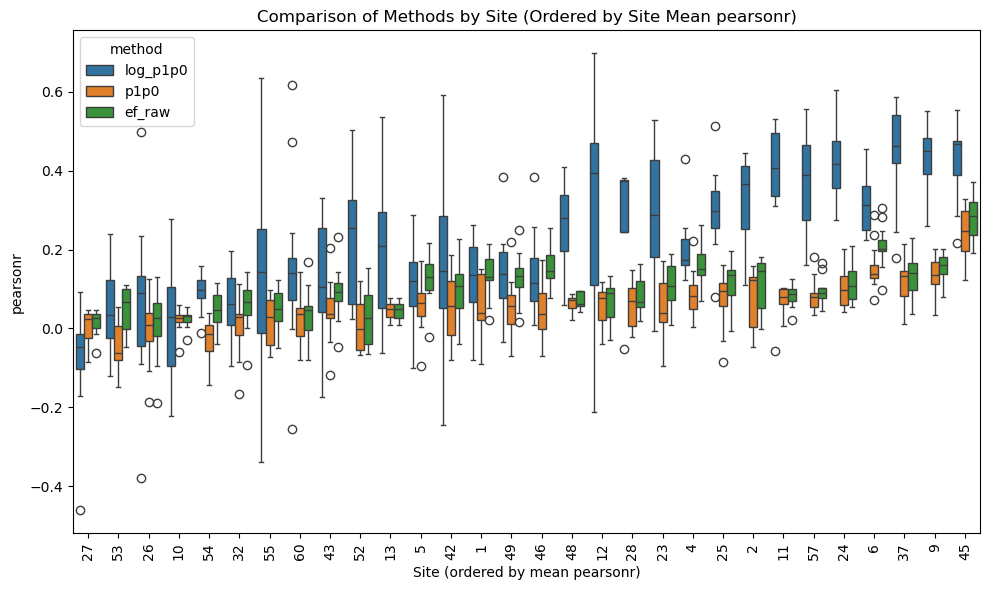

pearsonr statistics per Method (All Sites Combined):
              mean       min       max
method                                
ef_raw    0.098355 -0.188452  0.371393
log_p1p0  0.214709 -0.460849  0.698310
p1p0      0.058467 -0.187682  0.329646


In [196]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Compute mean r_squared per site (across all methods)
site_order = combined_df.groupby('site')['pearsonr'].mean().sort_values().index.tolist()

# Step 2: Plot with ordered x-axis
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='site', y='pearsonr', hue='method', order=site_order)

# Formatting
plt.xticks(rotation=90)
plt.xlabel("Site (ordered by mean pearsonr)")
plt.ylabel("pearsonr")
plt.title("Comparison of Methods by Site (Ordered by Site Mean pearsonr)")
plt.tight_layout()
plt.show()



# Compute mean, min, and max r_squared per method
r_squared_stats = combined_df.groupby('method')['pearsonr'].agg(['mean', 'min', 'max'])
# Print the summary
print("pearsonr statistics per Method (All Sites Combined):")
print(r_squared_stats)

In [102]:
combined_df

Unnamed: 0   sample  sp_correlation  pearsonr  r_squared  kendall_tau  \
0             0    1_1_1        0.145335  0.128769   0.016581     0.098212   
1             1    1_1_2        0.229218  0.201388   0.040557     0.154376   
2             2    1_1_3        0.311726  0.261336   0.068297     0.210088   
3             3    1_1_4        0.301508  0.140425   0.019719     0.205195   
4             4    1_1_5        0.264256  0.224883   0.050572     0.171918   
..          ...      ...             ...       ...        ...          ...   
970         321   60_1_8        0.666610  0.168056   0.028243     0.489589   
971         322   60_1_9        0.231119  0.005560   0.000031     0.163012   
972         323  60_1_10        0.316288 -0.035822   0.001283     0.231722   
973         324  60_1_11        0.495393  0.047556   0.002262     0.372151   
974         325  60_1_12        0.303231  0.054878   0.003012     0.211283   

     top_10  top_20     top_30  top_40  top_50     top_60  top_100  site  \
0       0.0     5.0  20.000000    32.5    28.0  31.666667     53.0     1   
1      20.0    10.0  13.333333    15.0    22.0  31.666667     52.0     1   
2       0.0    10.0  13.333333    20.0    22.0  28.333333     57.0     1   
3       0.0     5.0  13.333333    22.5    28.0  30.000000     53.0     1   
4      20.0    15.0  23.333333    17.5    22.0  30.000000     55.0     1   
..      ...     ...        ...     ...     ...        ...      ...   ...   
970     0.0    25.0  33.333333    35.0    34.0  38.333333     68.0    60   
971     0.0     0.0   3.333333    17.5    26.0  31.666667     56.0    60   
972    10.0     5.0  13.333333    15.0    24.0  28.333333     50.0    60   
973     0.0    30.0  30.000000    35.0    40.0  38.333333     61.0    60   
974     0.0    20.0  23.333333    32.5    36.0  36.666667     52.0    60   

     plot    method  
0       1  log_p1p0  
1       2  log_p1p0  
2       3  log_p1p0  
3       4  log_p1p0  
4       5  log_p1p0  
..    ...       ...  
970     8    ef_raw  
971     9    ef_raw  
972    10    ef_raw  
973    11    ef_raw  
974    12    ef_raw  

[975 rows x 16 columns]

In [60]:
results

sample  sp_correlation  pearsonr  r_squared  kendall_tau  top_10  \
0      1_1_1        0.145335  0.032593   0.001062     0.098212     0.0   
1      1_1_2        0.229218  0.139630   0.019497     0.154376    20.0   
2      1_1_3        0.311726  0.139116   0.019353     0.210088     0.0   
3      1_1_4        0.301508  0.019476   0.000379     0.205195     0.0   
4      1_1_5        0.264256  0.137474   0.018899     0.171918    20.0   
..       ...             ...       ...        ...          ...     ...   
321   60_1_8        0.659343  0.142002   0.020165     0.479782    10.0   
322   60_1_9        0.115362 -0.008888   0.000079     0.086582     0.0   
323  60_1_10        0.239435 -0.049768   0.002477     0.173123    10.0   
324  60_1_11        0.439590  0.037844   0.001432     0.329839     0.0   
325  60_1_12        0.204418  0.034916   0.001219     0.140599     0.0   

     top_20     top_30  top_40  top_50     top_60  top_100 site plot  
0       5.0  20.000000    32.5    28.0  31.666667     53.0    1    1  
1      10.0  13.333333    15.0    22.0  31.666667     52.0    1    2  
2      10.0  13.333333    20.0    22.0  28.333333     57.0    1    3  
3       5.0  13.333333    22.5    28.0  30.000000     53.0    1    4  
4      15.0  23.333333    17.5    22.0  30.000000     55.0    1    5  
..      ...        ...     ...     ...        ...      ...  ...  ...  
321    25.0  36.666667    35.0    36.0  38.333333     69.0   60    8  
322     5.0   6.666667    20.0    30.0  33.333333     52.0   60    9  
323     5.0  16.666667    22.5    26.0  33.333333     49.0   60   10  
324    30.0  30.000000    32.5    34.0  38.333333     56.0   60   11  
325    25.0  23.333333    27.5    30.0  35.000000     47.0   60   12  

[325 rows x 14 columns]

In [80]:
#results.to_csv('genomic_offset_firstgen_binom_reg_results.csv')

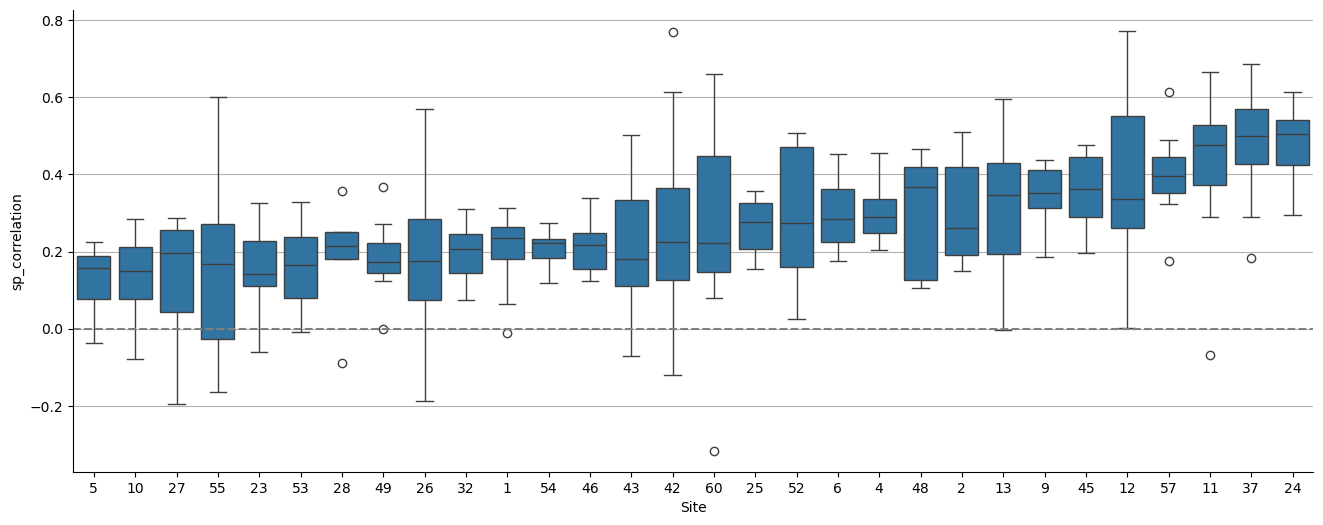

In [61]:
# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = results.groupby('site')['sp_correlation'].mean().sort_values()

# Set the size of the plot
plt.figure(figsize=(16, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.boxplot(data=results, y='sp_correlation', x='site', order=medians_results.index)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')


# Display the plot
plt.show()

In [14]:
cd_results_mean = pd.read_csv('../climate_distance/naive_climate_distance_top_ecotypes_mean.csv')

In [15]:
results_mean['site'] = results_mean['site'].astype(int)
# Add a new column to differentiate between the two DataFrames
results_mean['dataset'] = 'genomic_offset'
cd_results_mean['dataset'] = 'climatic_distance'
# Concatenate the two DataFrames
combined_results_mean = pd.concat([results_mean, cd_results_mean])

NameError: name 'results_mean' is not defined

In [26]:
results

Unnamed: 0   sample  sp_correlation  pearsonr  r_squared  kendall_tau  \
0             0    1_1_1        0.145335  0.032593   0.001062     0.098212   
1             1    1_1_2        0.229218  0.139630   0.019497     0.154376   
2             2    1_1_3        0.311726  0.139116   0.019353     0.210088   
3             3    1_1_4        0.301508  0.019476   0.000379     0.205195   
4             4    1_1_5        0.264256  0.137474   0.018899     0.171918   
..          ...      ...             ...       ...        ...          ...   
320         321   60_1_8        0.659343  0.142002   0.020165     0.479782   
321         322   60_1_9        0.115362 -0.008888   0.000079     0.086582   
322         323  60_1_10        0.239435 -0.049768   0.002477     0.173123   
323         324  60_1_11        0.439590  0.037844   0.001432     0.329839   
324         325  60_1_12        0.204418  0.034916   0.001219     0.140599   

     top_10  top_20     top_30  top_40  top_50     top_60  top_100  site  \
0       0.0     5.0  20.000000    32.5    28.0  31.666667     53.0     1   
1      20.0    10.0  13.333333    15.0    22.0  31.666667     52.0     1   
2       0.0    10.0  13.333333    20.0    22.0  28.333333     57.0     1   
3       0.0     5.0  13.333333    22.5    28.0  30.000000     53.0     1   
4      20.0    15.0  23.333333    17.5    22.0  30.000000     55.0     1   
..      ...     ...        ...     ...     ...        ...      ...   ...   
320    10.0    25.0  36.666667    35.0    36.0  38.333333     69.0    60   
321     0.0     5.0   6.666667    20.0    30.0  33.333333     52.0    60   
322    10.0     5.0  16.666667    22.5    26.0  33.333333     49.0    60   
323     0.0    30.0  30.000000    32.5    34.0  38.333333     56.0    60   
324     0.0    25.0  23.333333    27.5    30.0  35.000000     47.0    60   

     plot         dataset  
0       1  genomic_offset  
1       2  genomic_offset  
2       3  genomic_offset  
3       4  genomic_offset  
4       5  genomic_offset  
..    ...             ...  
320     8  genomic_offset  
321     9  genomic_offset  
322    10  genomic_offset  
323    11  genomic_offset  
324    12  genomic_offset  

[325 rows x 16 columns]

In [27]:
cd_results = pd.read_csv('../climate_distance/naive_climate_distance_top_ecotypes.csv')

In [31]:
cd_results = cd_results.rename(columns = {'index': 'sample'})

In [14]:
#cd_results_mean = pd.read_csv('../climate_distance/climate_distance_results_mean_leave_1_out.csv')

In [15]:
#cd_results = pd.read_csv('../climate_distance/naive_climate_distance_top_ecotypes.csv')

In [32]:
cd_model = pd.read_csv('../climate_distance/climate_distance_model_results_leave_1_out_ecotype_freq_top.csv')

In [34]:
cd_model = cd_model.rename(columns = {'index': 'sample'})

In [35]:
baseline_pairwise_topecotypes_samples = pd.read_csv('../binomial_regression_lastgen_go/baseline_pairwise_topecotypes_samples_top.csv')

In [36]:
baseline_pairwise_topecotypes_samples

sp_correlation  pearsonr  r_squared  kendall_tau  top_10  top_20  \
0           0.582004  0.100517   0.010104     0.483004    10.0    25.0   
1           0.620070  0.274736   0.075480     0.491813    40.0    25.0   
2           0.570565  0.302080   0.091252     0.440768    20.0    10.0   
3           0.603347  0.066503   0.004423     0.482599    10.0    25.0   
4           0.616682  0.168282   0.028319     0.493469    30.0    20.0   
...              ...       ...        ...          ...     ...     ...   
1876        0.783460  0.399482   0.159586     0.627931    20.0    40.0   
1877        0.609095 -0.022335   0.000499     0.457453     0.0    15.0   
1878        0.736136  0.083087   0.006904     0.643490    10.0    25.0   
1879        0.659067  0.034134   0.001165     0.519764     0.0    10.0   
1880        0.758910  0.011356   0.000129     0.625647    10.0    35.0   

         top_30  top_40  top_50     top_60  top_100  site          samples  
0     26.666667    32.5    42.0  53.333333     68.0     1      1_2_2-1_2_3  
1     20.000000    32.5    46.0  46.666667     71.0     1      1_2_2-1_3_1  
2     10.000000    25.0    40.0  43.333333     66.0     1      1_2_2-1_3_4  
3     16.666667    32.5    44.0  51.666667     71.0     1      1_2_2-1_3_5  
4     13.333333    27.5    44.0  50.000000     70.0     1      1_2_2-1_3_6  
...         ...     ...     ...        ...      ...   ...              ...  
1876  43.333333    57.5    60.0  63.333333     81.0    60   60_1_9-60_1_11  
1877  26.666667    37.5    54.0  60.000000     72.0    60   60_1_9-60_1_12  
1878  43.333333    55.0    62.0  70.000000     85.0    60  60_1_10-60_1_11  
1879  33.333333    45.0    58.0  63.333333     80.0    60  60_1_10-60_1_12  
1880  46.666667    55.0    68.0  73.333333     81.0    60  60_1_11-60_1_12  

[1881 rows x 13 columns]

In [37]:
results['site'] = results['site'].astype(int)
baseline_pairwise_topecotypes_samples['site'] = baseline_pairwise_topecotypes_samples['site'].astype(int)
# Add a new column to differentiate between the two DataFrames
results['dataset'] = 'genomic_offset'
cd_results['dataset'] = 'climatic_distance'

cd_model['dataset'] = 'climatic_distance_model'
baseline_pairwise_topecotypes_samples['dataset'] = 'baseline_pairwise_samples'

In [38]:
combined_results = pd.concat([results, cd_results, baseline_pairwise_topecotypes_samples, cd_model],axis=0)  # ,baseline_pairwise_topecotypes_samples

In [20]:
combined_results = combined_results.reset_index(drop=True)

In [39]:
combined_results

Unnamed: 0   sample  sp_correlation  pearsonr  r_squared  kendall_tau  \
0           0.0    1_1_1        0.145335  0.032593   0.001062     0.098212   
1           1.0    1_1_2        0.229218  0.139630   0.019497     0.154376   
2           2.0    1_1_3        0.311726  0.139116   0.019353     0.210088   
3           3.0    1_1_4        0.301508  0.019476   0.000379     0.205195   
4           4.0    1_1_5        0.264256  0.137474   0.018899     0.171918   
..          ...      ...             ...       ...        ...          ...   
343         NaN   60_1_8        0.437185  0.120607   0.014546     0.291766   
344         NaN   60_1_9        0.120858  0.069203   0.004789     0.082447   
345         NaN  60_1_10        0.321997  0.197681   0.039078     0.222536   
346         NaN  60_1_11        0.386155  0.227219   0.051628     0.268620   
347         NaN  60_1_12        0.328359  0.159667   0.025494     0.227773   

     top_10  top_20     top_30  top_40  top_50     top_60  top_100  site  \
0       0.0     5.0  20.000000    32.5    28.0  31.666667     53.0     1   
1      20.0    10.0  13.333333    15.0    22.0  31.666667     52.0     1   
2       0.0    10.0  13.333333    20.0    22.0  28.333333     57.0     1   
3       0.0     5.0  13.333333    22.5    28.0  30.000000     53.0     1   
4      20.0    15.0  23.333333    17.5    22.0  30.000000     55.0     1   
..      ...     ...        ...     ...     ...        ...      ...   ...   
343    10.0    15.0  26.666667    30.0    30.0        NaN      NaN    60   
344    10.0    10.0  16.666667    17.5    28.0        NaN      NaN    60   
345    30.0    25.0  20.000000    25.0    30.0        NaN      NaN    60   
346    10.0    30.0  26.666667    32.5    42.0        NaN      NaN    60   
347    20.0    40.0  30.000000    35.0    40.0        NaN      NaN    60   

     plot                  dataset  level_0 samples  
0     1.0           genomic_offset      NaN     NaN  
1     2.0           genomic_offset      NaN     NaN  
2     3.0           genomic_offset      NaN     NaN  
3     4.0           genomic_offset      NaN     NaN  
4     5.0           genomic_offset      NaN     NaN  
..    ...                      ...      ...     ...  
343   8.0  climatic_distance_model      NaN     NaN  
344   9.0  climatic_distance_model      NaN     NaN  
345  10.0  climatic_distance_model      NaN     NaN  
346  11.0  climatic_distance_model      NaN     NaN  
347  12.0  climatic_distance_model      NaN     NaN  

[2902 rows x 18 columns]

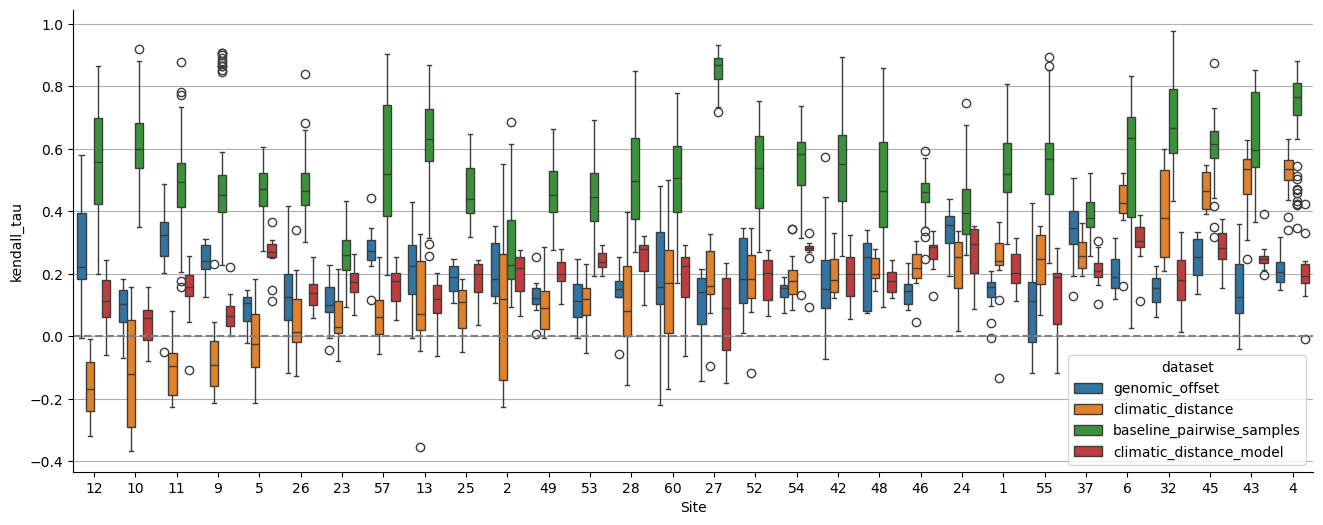

In [30]:
# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = cd_results.groupby('site')['kendall_tau'].mean().sort_values()

# Set the size of the plot
plt.figure(figsize=(16, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.boxplot(data=combined_results, y='kendall_tau', x='site', hue='dataset', order=medians_results.index)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')


# Display the plot
plt.show()

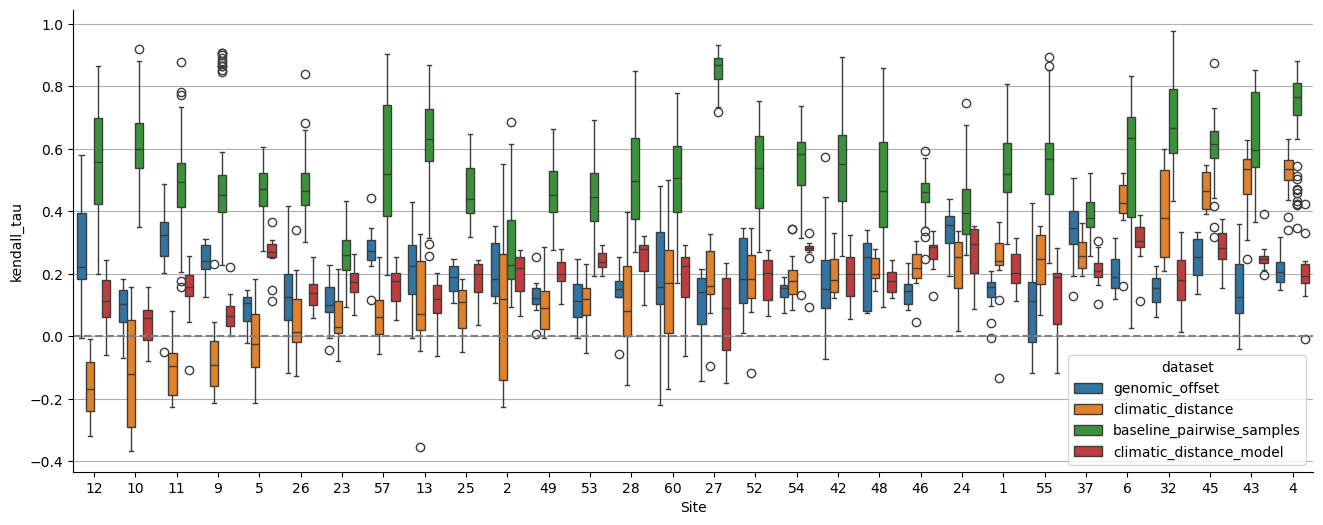

In [32]:
# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = cd_results.groupby('site')['kendall_tau'].mean().sort_values()

# Set the size of the plot
plt.figure(figsize=(16, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.boxplot(data=combined_results, y='kendall_tau', x='site', hue='dataset', order=medians_results.index)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')


# Display the plot
plt.show()

In [33]:
#combined_results.to_csv('combined_results_onlysign_p_top_ecotypes.csv',index=None)

In [125]:
combined_results.head(1)

index  sp_correlation  pearsonr  r_squared  kendall_tau  top_10  top_20  \
0  1_2_2        0.595953  0.155653   0.024228     0.419462    20.0    15.0   

      top_30  top_40  top_50  top_60  top_100  site  plot         dataset  \
0  26.666667    37.5    34.0    35.0     66.0     1   2.0  genomic_offset   

   level_0 samples  
0      NaN     NaN

In [41]:
sort_bio1_int

array([], dtype=int64)

In [40]:
order_touse = sort_bio1_int

array([], dtype=int64)

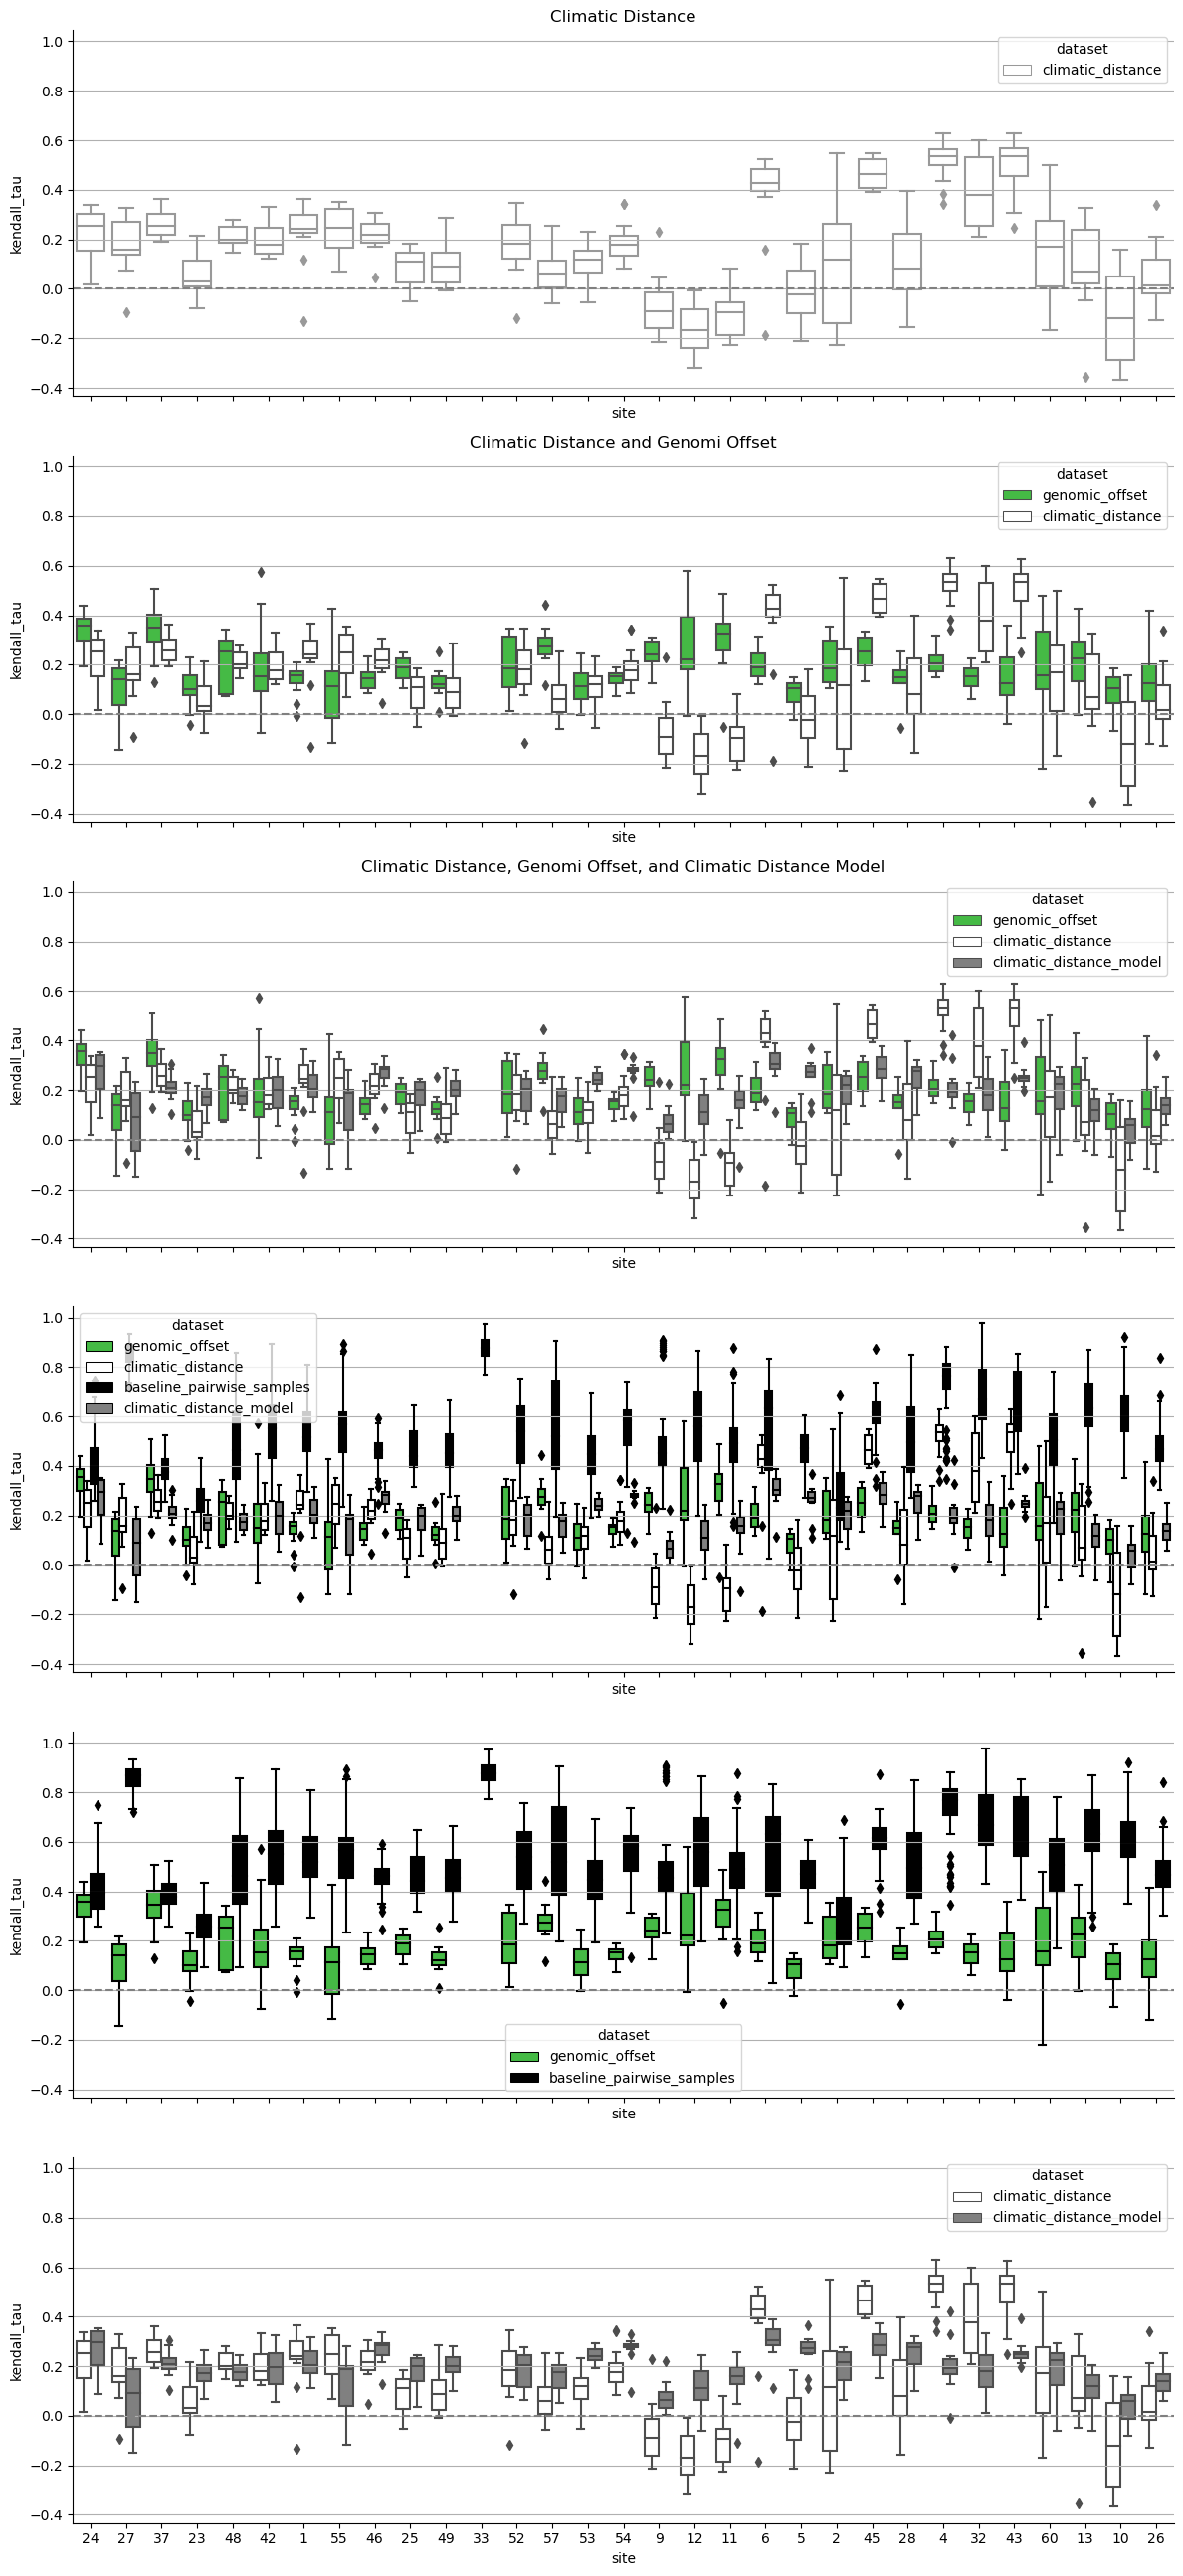

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

variable = 'kendall_tau'
order_touse = sort_bio1_int

# Define a custom color palette mapping each dataset to a specific color
palette = {
    'climatic_distance': 'white',  # Light green
    'genomic_offset': '#32CD32',     # Dark green
    'climatic_distance_model': 'grey',  # Lime green
    'baseline_pairwise_samples': 'black' # Forest green
}


# Create 4 subplots (4 rows, 1 column)
fig, axes = plt.subplots(6, 1, figsize=(12, 26), sharex=True, sharey=True)

# Plot 1: Only 'climatic distance'
sns.boxplot(data=combined_results[combined_results['dataset'] == 'climatic_distance'], order=order_touse,
            y=variable, x='site', hue='dataset', ax=axes[0], palette=palette)
axes[0].axhline(0, color='grey', linestyle='--')
axes[0].set_title('Climatic Distance')

# Plot 2: 'climatic distance' and 'genomi_offset'
sns.boxplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'genomic_offset'])], order=order_touse,
            y=variable, x='site', hue='dataset', ax=axes[1], palette=palette)
axes[1].axhline(0, color='grey', linestyle='--')
axes[1].set_title('Climatic Distance and Genomi Offset')

# Plot 3: 'climatic distance', 'genomi_offset', and 'climatic_dsitance model'
sns.boxplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'genomic_offset', 'climatic_distance_model'])], order=order_touse,
            y=variable, x='site', hue='dataset', ax=axes[2], palette=palette)
axes[2].axhline(0, color='grey', linestyle='--')
axes[2].set_title('Climatic Distance, Genomi Offset, and Climatic Distance Model')

# Plot 4: All datasets
sns.boxplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'genomic_offset', 'climatic_distance_model', 'baseline_pairwise_samples'])], 
            y=variable, x='site', hue='dataset', order=order_touse, ax=axes[3], palette=palette)
axes[3].axhline(0, color='grey', linestyle='--')


# Plot 4: All datasets
sns.boxplot(data=combined_results[combined_results['dataset'].isin(['baseline_pairwise_samples', 'genomic_offset'])], 
            y=variable, x='site', hue='dataset', order=order_touse, ax=axes[4], palette=palette)
axes[4].axhline(0, color='grey', linestyle='--')


# Plot 4: All datasets
sns.boxplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'climatic_distance_model'])], 
            y=variable, x='site', hue='dataset', order=order_touse, ax=axes[5], palette=palette)
axes[5].axhline(0, color='grey', linestyle='--')


# Set common properties
for ax in axes.flat:
    ax.grid(axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


In [25]:
combined_results

Unnamed: 0 sample  sp_correlation  pearsonr  r_squared  kendall_tau  \
0            0.0  1_1_1        0.145335  0.032593   0.001062     0.098212   
1            1.0  1_1_2        0.229218  0.139630   0.019497     0.154376   
2            2.0  1_1_3        0.311726  0.139116   0.019353     0.210088   
3            3.0  1_1_4        0.301508  0.019476   0.000379     0.205195   
4            4.0  1_1_5        0.264256  0.137474   0.018899     0.171918   
...          ...    ...             ...       ...        ...          ...   
2897         NaN    NaN        0.437185  0.120607   0.014546     0.291766   
2898         NaN    NaN        0.120858  0.069203   0.004789     0.082447   
2899         NaN    NaN        0.321997  0.197681   0.039078     0.222536   
2900         NaN    NaN        0.386155  0.227219   0.051628     0.268620   
2901         NaN    NaN        0.328359  0.159667   0.025494     0.227773   

      top_10  top_20     top_30  top_40  top_50     top_60  top_100  site  \
0        0.0     5.0  20.000000    32.5    28.0  31.666667     53.0     1   
1       20.0    10.0  13.333333    15.0    22.0  31.666667     52.0     1   
2        0.0    10.0  13.333333    20.0    22.0  28.333333     57.0     1   
3        0.0     5.0  13.333333    22.5    28.0  30.000000     53.0     1   
4       20.0    15.0  23.333333    17.5    22.0  30.000000     55.0     1   
...      ...     ...        ...     ...     ...        ...      ...   ...   
2897    10.0    15.0  26.666667    30.0    30.0        NaN      NaN    60   
2898    10.0    10.0  16.666667    17.5    28.0        NaN      NaN    60   
2899    30.0    25.0  20.000000    25.0    30.0        NaN      NaN    60   
2900    10.0    30.0  26.666667    32.5    42.0        NaN      NaN    60   
2901    20.0    40.0  30.000000    35.0    40.0        NaN      NaN    60   

      plot                  dataset  level_0    index samples  
0      1.0           genomic_offset      NaN      NaN     NaN  
1      2.0           genomic_offset      NaN      NaN     NaN  
2      3.0           genomic_offset      NaN      NaN     NaN  
3      4.0           genomic_offset      NaN      NaN     NaN  
4      5.0           genomic_offset      NaN      NaN     NaN  
...    ...                      ...      ...      ...     ...  
2897   8.0  climatic_distance_model      NaN   60_1_8     NaN  
2898   9.0  climatic_distance_model      NaN   60_1_9     NaN  
2899  10.0  climatic_distance_model      NaN  60_1_10     NaN  
2900  11.0  climatic_distance_model      NaN  60_1_11     NaN  
2901  12.0  climatic_distance_model      NaN  60_1_12     NaN  

[2902 rows x 19 columns]

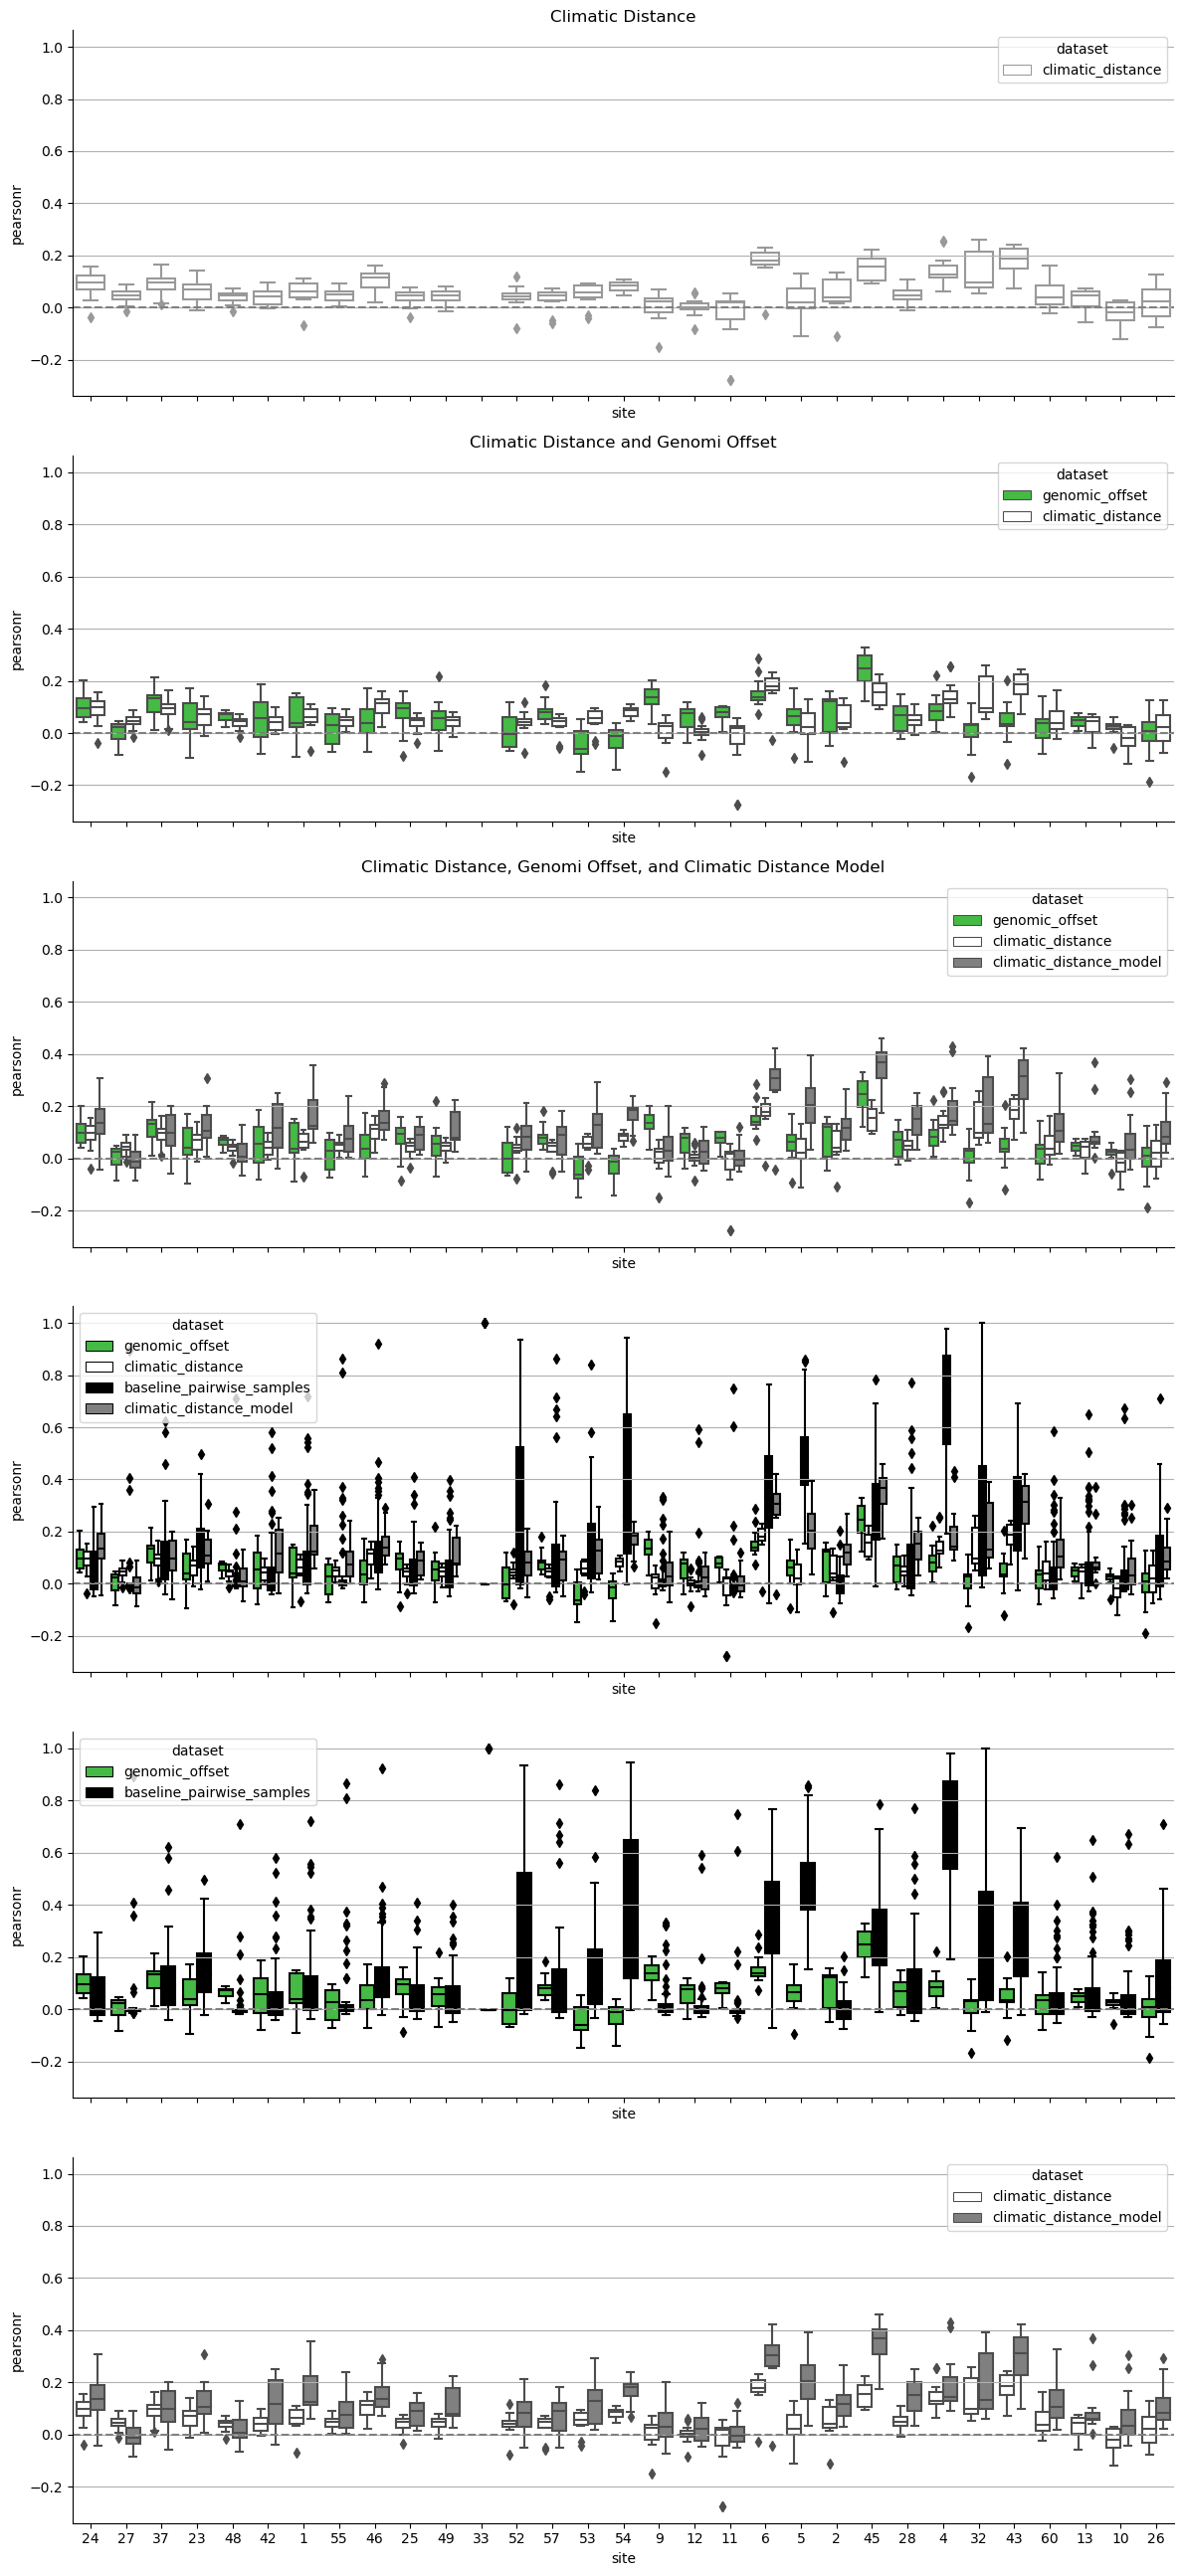

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

variable = 'pearsonr'
order_touse = sort_bio1_int

# Define a custom color palette mapping each dataset to a specific color
palette = {
    'climatic_distance': 'white',  # Light green
    'genomic_offset': '#32CD32',     # Dark green
    'climatic_distance_model': 'grey',  # Lime green
    'baseline_pairwise_samples': 'black' # Forest green
}


# Create 4 subplots (4 rows, 1 column)
fig, axes = plt.subplots(6, 1, figsize=(12, 26), sharex=True, sharey=True)

# Plot 1: Only 'climatic distance'
sns.boxplot(data=combined_results[combined_results['dataset'] == 'climatic_distance'], order=order_touse,
            y=variable, x='site', hue='dataset', ax=axes[0], palette=palette)
axes[0].axhline(0, color='grey', linestyle='--')
axes[0].set_title('Climatic Distance')

# Plot 2: 'climatic distance' and 'genomi_offset'
sns.boxplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'genomic_offset'])], order=order_touse,
            y=variable, x='site', hue='dataset', ax=axes[1], palette=palette)
axes[1].axhline(0, color='grey', linestyle='--')
axes[1].set_title('Climatic Distance and Genomi Offset')

# Plot 3: 'climatic distance', 'genomi_offset', and 'climatic_dsitance model'
sns.boxplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'genomic_offset', 'climatic_distance_model'])], order=order_touse,
            y=variable, x='site', hue='dataset', ax=axes[2], palette=palette)
axes[2].axhline(0, color='grey', linestyle='--')
axes[2].set_title('Climatic Distance, Genomi Offset, and Climatic Distance Model')

# Plot 4: All datasets
sns.boxplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'genomic_offset', 'climatic_distance_model', 'baseline_pairwise_samples'])], 
            y=variable, x='site', hue='dataset', order=order_touse, ax=axes[3], palette=palette)
axes[3].axhline(0, color='grey', linestyle='--')


# Plot 4: All datasets
sns.boxplot(data=combined_results[combined_results['dataset'].isin(['baseline_pairwise_samples', 'genomic_offset'])], 
            y=variable, x='site', hue='dataset', order=order_touse, ax=axes[4], palette=palette)
axes[4].axhline(0, color='grey', linestyle='--')


# Plot 4: All datasets
sns.boxplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'climatic_distance_model'])], 
            y=variable, x='site', hue='dataset', order=order_touse, ax=axes[5], palette=palette)
axes[5].axhline(0, color='grey', linestyle='--')


# Set common properties
for ax in axes.flat:
    ax.grid(axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


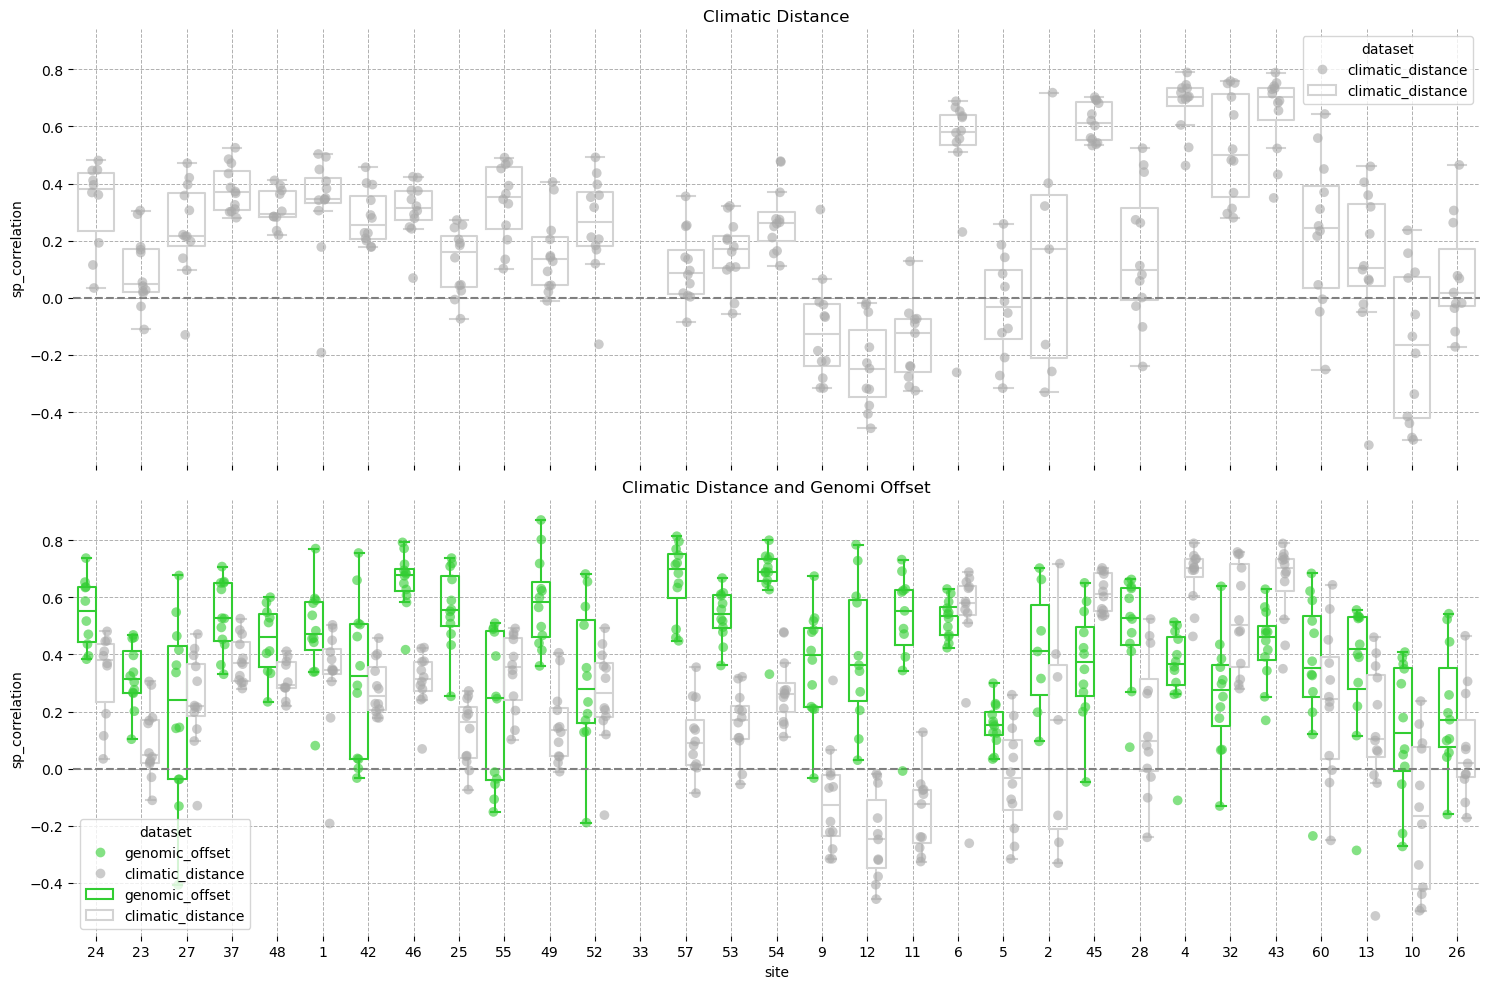

In [44]:
variable = 'sp_correlation'
order_touse = sort_bio1
s_value = 7
alpha_value = 0.6 
# Define a custom color palette mapping each dataset to a specific color
palette_stripplot = {
    'climatic_distance': 'darkgrey',  # Light green
    'genomic_offset': '#32CD32',     # Dark green
    'climatic_distance_model': 'grey',  # Lime green
    'baseline_pairwise_samples': 'black' # Forest green
}

palette_boxplot = {
    'climatic_distance': 'lightgrey',  # Light green
    'genomic_offset': '#32CD32',     # Dark green
    'climatic_distance_model': 'grey',  # Lime green
    'baseline_pairwise_samples': 'black' # Forest green

}

#combined_results.
# Create 4 subplots (4 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True, sharey=True)

# Plot 1: Only 'climatic distance'
sns.stripplot(data=combined_results[combined_results['dataset'] == 'climatic_distance'], order=order_touse,s=s_value,alpha=alpha_value,
            y=variable, x='site', hue='dataset', ax=axes[0], palette=palette_stripplot)

sns.boxplot(data=combined_results[combined_results['dataset'] == 'climatic_distance'], order = sort_bio1.astype(int),
            y=variable, x='site', hue='dataset', ax=axes[0],fill=False,
            showfliers=False, color='black',palette=palette_boxplot)

axes[0].axhline(0, color='grey', linestyle='--')
axes[0].set_title('Climatic Distance')

# Plot 2: 'climatic distance' and 'genomi_offset'
sns.stripplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'genomic_offset'])], order=order_touse,s=s_value,alpha=alpha_value,
            y=variable, x='site', hue='dataset', ax=axes[1], palette=palette_stripplot, dodge=True)

box_plot = sns.boxplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'genomic_offset'])], 
                       order=sort_bio1.astype(int), y=variable, x='site', 
                       hue='dataset', ax=axes[1],fill=False,
                       showfliers=False, palette=palette_boxplot)

# Create the boxplot
axes[1].axhline(0, color='grey', linestyle='--')
axes[1].set_title('Climatic Distance and Genomi Offset')

# Set common properties
for ax in axes.flat:
    ax.grid(axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)


axes[0].grid(True, which='major', axis='both', linestyle='--', linewidth=0.7)
axes[1].grid(True, which='major', axis='both', linestyle='--', linewidth=0.7)


# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


In [190]:
order_touse = sort_bio1

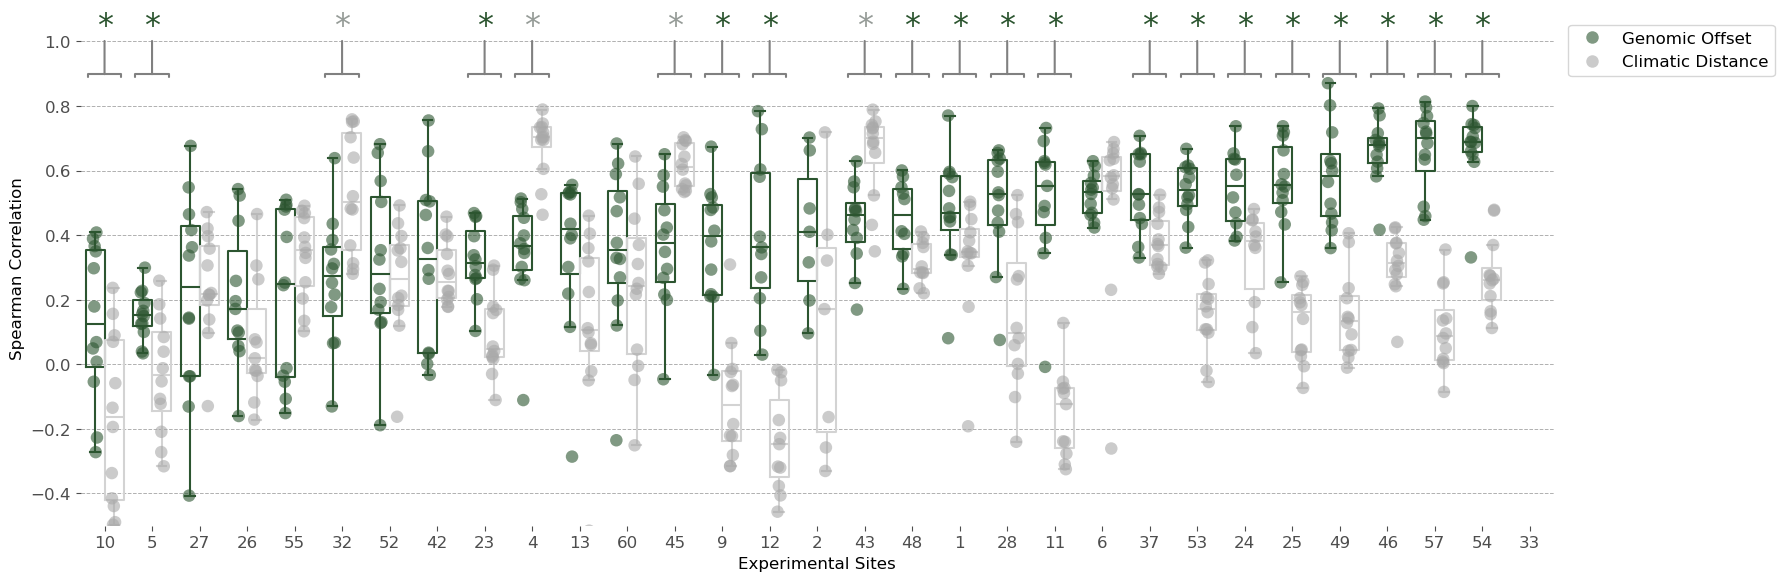

In [211]:
variable = 'sp_correlation'
order_touse = sort_bio1
s_value = 9
alpha_value = 0.6 
font_size = 12

# Define a custom color palette mapping each dataset to a specific color
green = '#2C5530'
grey = '#969C98'
# Define a custom color palette mapping each dataset to a specific color
palette_stripplot = {
    'climatic_distance': 'darkgrey',  # Light green
    'genomic_offset': green,     # Dark green
    'climatic_distance_model': grey,  # Lime green
    'baseline_pairwise_samples': 'black' # Forest green
}

palette_boxplot = {
    'climatic_distance': 'lightgrey',  # Light green
    'genomic_offset': green,     # Dark green
    'climatic_distance_model': grey,  # Lime green
    'baseline_pairwise_samples': 'black' # Forest green

}

# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = results.groupby('site')[variable].mean().sort_values()
order_touse = medians_results.index
#combined_results.
# Create 4 subplots (4 rows, 1 column)
fig, ax = plt.subplots(figsize=(18, 6))

# Plot 2: 'climatic distance' and 'genomi_offset'
stripplot = sns.stripplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'genomic_offset'])], order=order_touse,s=s_value,alpha=alpha_value,
            y=variable, x='site', hue='dataset', palette=palette_stripplot, dodge=True)

box_plot = sns.boxplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'genomic_offset'])], 
                       order=sort_bio1.astype(int), y=variable, x='site', 
                       hue='dataset',fill=False,
                       showfliers=False, palette=palette_boxplot,
                      legend= False)


# Add stars for statistical significance and color them based on which one is higher
for site in test_results:
    p_value = test_results[site].pvalue
    if p_value < 0.05:
        x_position = list(order_touse.astype(int)).index(site)
        y_max = combined_results[combined_results['site'] == site][variable].max()
        site_data = merged_data[merged_data['site'] == site]
        genomic_mean = site_data[variable + '_geno'].mean()
        climatic_mean = site_data[variable + '_clim'].mean()
        
        if genomic_mean > climatic_mean:
            star_color = green  # Green if genomic offset is higher
        else:
            star_color = grey  # Grey if climatic distance is higher

        ymax = 0.95
        # Add stars for significance with the appropriate color
        ax.text(x_position, ymax + 0.05, "*", ha='center', va='bottom', color=star_color, fontsize=23)

        # Add horizontal bracket (bracket over the comparison)
        ax.annotate('', xy=(x_position,ymax + 0.06), xycoords='data',
                    xytext=(x_position, ymax - 0.06), textcoords='data',
                    arrowprops={'arrowstyle': ']-', 'color': 'grey', 'linewidth': 1.5})

ax.grid(axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7)
# Customizing the legend to show only stripplot legend items
# Customizing the legend to show only stripplot legend items
handles, labels = ax.get_legend_handles_labels()
legend_handles = handles[:len(stripplot.get_legend_handles_labels()[0])]  # Keep only stripplot legend handles
legend_labels = ['Genomic Offset', 'Climatic Distance']  # Custom legend labels

# Adding the filtered legend back to the plot
ax.legend(legend_handles, legend_labels, bbox_to_anchor=(1.01, 0.97), loc='upper left', borderaxespad=0.)
ax.set_ylim(-0.5, 1.1)  

ax.set_xlabel('Experimental Sites')
ax.set_ylabel('Spearman Correlation')
# Adjust layout
plt.tight_layout()

plt.rc('font', family='sans-serif', size=font_size, weight='normal')  # Regular font size
plt.rc('axes', titlesize=font_size, labelsize=font_size)  # Title and label size for axes
plt.rc('xtick', labelsize=font_size)  # X tick labels size
plt.rc('ytick', labelsize=font_size)  # Y tick labels size
dark_grey = '#4D4D4D' 
plt.tick_params(axis='both', colors=dark_grey)  # Set tick colors

plt.savefig('spearman_go_vs_climatic_distance_ordergo.png')
plt.savefig('spearman_go_vs_climatic_distance_ordergo.svg')

# Display the plot
plt.show()


In [254]:
from itertools import combinations
from scipy.stats import mannwhitneyu
import pandas as pd

# Define the order of your groups
groups = ['climatic_distance',  'climatic_distance_model', 'genomic_offset', 'baseline_pairwise_samples']  # ['climatic_distance',  'climatic_distance_model', 'genomic_offset', 'baseline_pairwise_samples']

# Create an empty DataFrame to store pairwise p-values
p_values = pd.DataFrame(index=groups, columns=groups)

# Loop over each pair of groups and perform Wilcoxon rank-sum test
for group1, group2 in combinations(groups, 2):
    group1_data = combined_results[combined_results['dataset'] == group1]['sp_correlation']
    group2_data = combined_results[combined_results['dataset'] == group2]['sp_correlation']
    
    # Perform the Wilcoxon rank-sum test
    stat, p_value = mannwhitneyu(group1_data, group2_data, alternative='two-sided')
    
    # Store the p-value
    p_values.loc[group1, group2] = p_value
    p_values.loc[group2, group1] = p_value  # fill in symmetric value

In [255]:
p_values

climatic_distance climatic_distance_model  \
climatic_distance                       NaN                0.008757   
climatic_distance_model            0.008757                     NaN   
genomic_offset                          0.0                     0.0   
baseline_pairwise_samples               0.0                     0.0   

                          genomic_offset baseline_pairwise_samples  
climatic_distance                    0.0                       0.0  
climatic_distance_model              0.0                       0.0  
genomic_offset                       NaN                       0.0  
baseline_pairwise_samples            0.0                       NaN

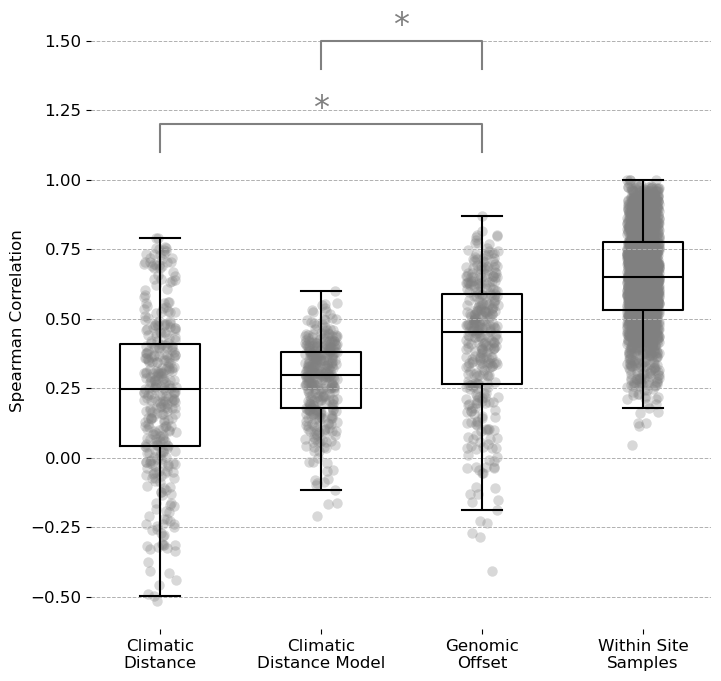

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu

# Define the order of your groups
order = ['climatic_distance', 'climatic_distance_model', 'genomic_offset', 'baseline_pairwise_samples']
ticks = ['Climatic\nDistance', 'Climatic\nDistance Model', 'Genomic\nOffset', 'Within Site\nSamples']

# Initialize the plot
plt.figure(figsize=(8, 8)) 
ax = sns.stripplot(data=combined_results, y='sp_correlation', x='dataset', order=order, color='grey', alpha=0.3, s=7.5, zorder=1)
sns.boxplot(data=combined_results, y='sp_correlation', x='dataset', order=order, showfliers=False, color='black', width=0.5, zorder=2, fill=False)

# Perform pairwise Mann-Whitney U tests between the relevant groups
group_genomic_offset = combined_results[combined_results['dataset'] == 'genomic_offset']['sp_correlation']
group_climatic_distance = combined_results[combined_results['dataset'] == 'climatic_distance']['sp_correlation']
group_climatic_distance_model = combined_results[combined_results['dataset'] == 'climatic_distance_model']['sp_correlation']

# Mann-Whitney U test between 'genomic_offset' and 'climatic_distance'
stat, p_value_1 = mannwhitneyu(group_genomic_offset, group_climatic_distance, alternative='two-sided')

# Mann-Whitney U test between 'genomic_offset' and 'climatic_distance_model'
stat, p_value_2 = mannwhitneyu(group_genomic_offset, group_climatic_distance_model, alternative='two-sided')

# Define significance threshold
significance_threshold = 0.05

# Add stars for significant comparisons
ymax = combined_results['sp_correlation'].max() + 0.1
height_increment = 0.1

# Add stars and brackets if significant for 'genomic_offset' vs 'climatic_distance'
if p_value_1 < significance_threshold:
    x1, x2 = order.index('genomic_offset'), order.index('climatic_distance')  # positions of the groups
    y, h, col = ymax, height_increment, 'grey'  # height and color of the annotation
    ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
    ax.text((x1 + x2) * 0.5, y + h, "*", ha='center', va='bottom', color='grey', fontsize=23)

# Add stars and brackets if significant for 'genomic_offset' vs 'climatic_distance_model'
if p_value_2 < significance_threshold:
    x1, x2 = order.index('genomic_offset'), order.index('climatic_distance_model')  # positions of the groups
    y, h, col = ymax + 0.3, height_increment, 'grey'  # increment height slightly to avoid overlap
    ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
    ax.text((x1 + x2) * 0.5, y + h, "*", ha='center', va='bottom', color='grey', fontsize=23)

# Customize axis labels and ticks
plt.xticks([0, 1, 2, 3], ticks)
plt.xlabel('')
plt.ylabel('Spearman Correlation')

# Add grid to the background for y-axis
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7)

# Remove all spines
sns.despine(left=True, right=True, top=True, bottom=True)


plt.savefig('go_cm_pairwise_samples_overall.png', )
plt.savefig('go_cm_pairwise_samples_overall.svg')

# Show the plot
plt.show()


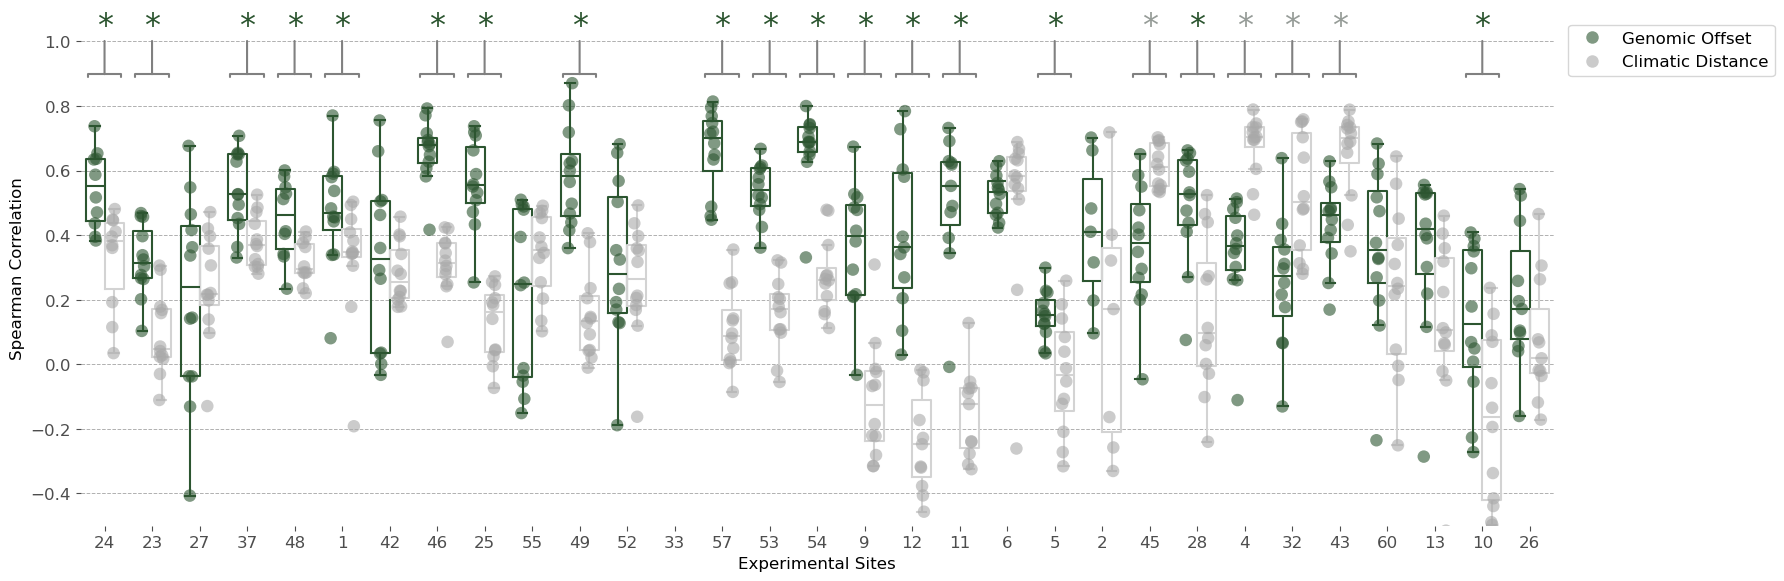

In [210]:
variable = 'sp_correlation'
order_touse = sort_bio1
s_value = 9
alpha_value = 0.6 

green = '#2C5530'
grey = '#969C98'
# Define a custom color palette mapping each dataset to a specific color
palette_stripplot = {
    'climatic_distance': 'darkgrey',  # Light green
    'genomic_offset': green,     # Dark green
    'climatic_distance_model': grey,  # Lime green
    'baseline_pairwise_samples': 'black' # Forest green
}

palette_boxplot = {
    'climatic_distance': 'lightgrey',  # Light green
    'genomic_offset': green,     # Dark green
    'climatic_distance_model': grey,  # Lime green
    'baseline_pairwise_samples': 'black' # Forest green

}

# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = results.groupby('site')[variable].mean().sort_values()
#combined_results.
# Create 4 subplots (4 rows, 1 column)
fig, ax = plt.subplots(figsize=(18, 6))

# Plot 2: 'climatic distance' and 'genomi_offset'
stripplot = sns.stripplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'genomic_offset'])], order=order_touse,s=s_value,alpha=alpha_value,
            y=variable, x='site', hue='dataset', palette=palette_stripplot, dodge=True)

box_plot = sns.boxplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'genomic_offset'])], 
                       order=sort_bio1.astype(int), y=variable, x='site', 
                       hue='dataset',fill=False,
                       showfliers=False, palette=palette_boxplot,
                      legend= False)


# Add stars for statistical significance and color them based on which one is higher
for site in test_results:
    p_value = test_results[site].pvalue
    if p_value < 0.05:
        x_position = list(order_touse.astype(int)).index(site)
        y_max = combined_results[combined_results['site'] == site][variable].max()
        site_data = merged_data[merged_data['site'] == site]
        genomic_mean = site_data[variable + '_geno'].mean()
        climatic_mean = site_data[variable + '_clim'].mean()
        
        if genomic_mean > climatic_mean:
            star_color = green  # Green if genomic offset is higher
        else:
            star_color = grey  # Grey if climatic distance is higher

        ymax = 0.95
        # Add stars for significance with the appropriate color
        ax.text(x_position, ymax + 0.05, "*", ha='center', va='bottom', color=star_color, fontsize=23)

        # Add horizontal bracket (bracket over the comparison)
        ax.annotate('', xy=(x_position,ymax + 0.06), xycoords='data',
                    xytext=(x_position, ymax - 0.06), textcoords='data',
                    arrowprops={'arrowstyle': ']-', 'color': 'grey', 'linewidth': 1.5})

ax.grid(axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7)
# Customizing the legend to show only stripplot legend items
# Customizing the legend to show only stripplot legend items
handles, labels = ax.get_legend_handles_labels()
legend_handles = handles[:len(stripplot.get_legend_handles_labels()[0])]  # Keep only stripplot legend handles
legend_labels = ['Genomic Offset', 'Climatic Distance']  # Custom legend labels

# Adding the filtered legend back to the plot
ax.legend(legend_handles, legend_labels, bbox_to_anchor=(1.01, 0.97), loc='upper left', borderaxespad=0.)
ax.set_ylim(-0.5, 1.1)  

ax.set_xlabel('Experimental Sites')
ax.set_ylabel('Spearman Correlation')
# Adjust layout


plt.rc('font', family='sans-serif', size=font_size, weight='normal')  # Regular font size
plt.rc('axes', titlesize=font_size, labelsize=font_size)  # Title and label size for axes
plt.rc('xtick', labelsize=font_size)  # X tick labels size
plt.rc('ytick', labelsize=font_size)  # Y tick labels size
dark_grey = '#4D4D4D' 
plt.tick_params(axis='both', colors=dark_grey)  # Set tick colors

plt.savefig('spearman_go_vs_climatic_distance_orderbio1.png')
plt.savefig('spearman_go_vs_climatic_distance_orderbio1.svg')


plt.tight_layout()

# Display the plot
plt.show()


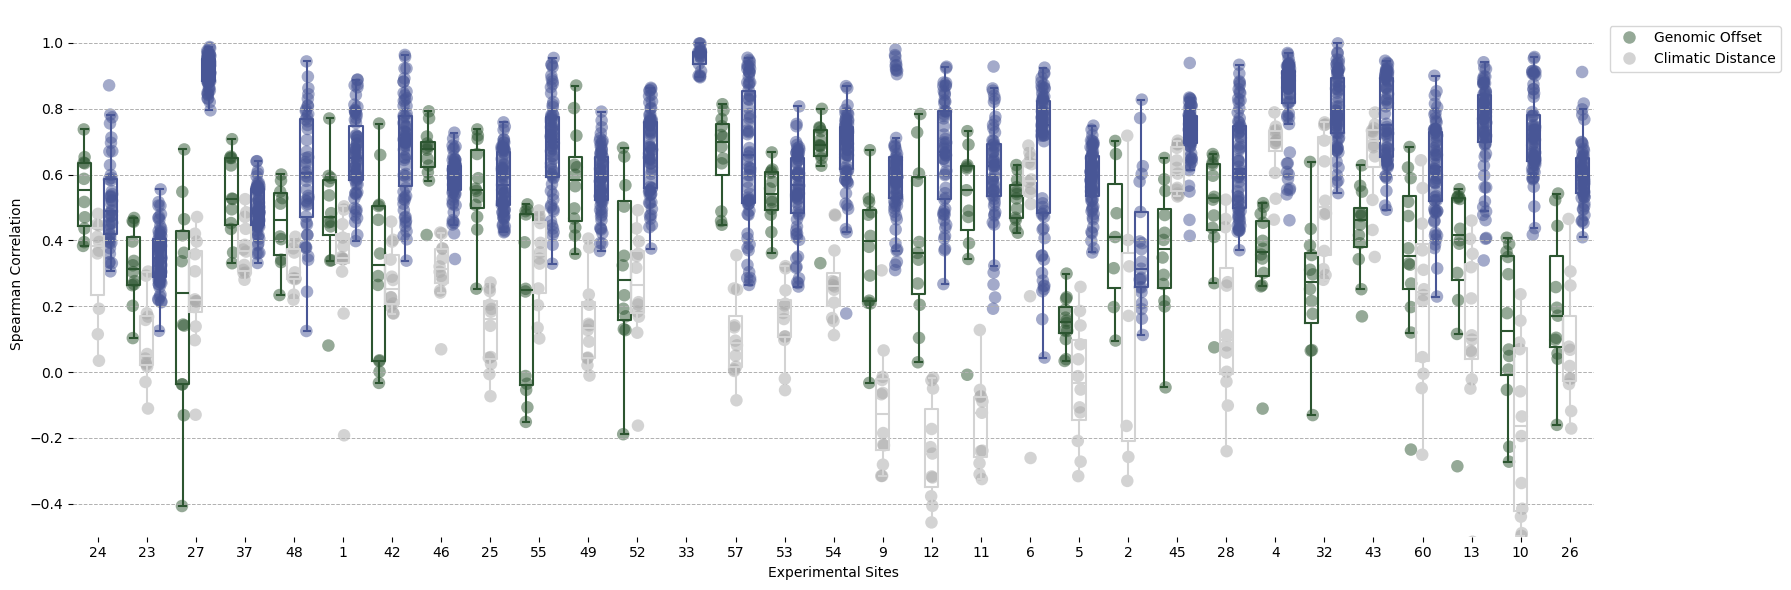

In [203]:
variable = 'sp_correlation'
order_touse = sort_bio1
s_value = 9
alpha_value = 0.5

green = '#2C5530'
grey = '#969C98'
black = '#485696'
# Define a custom color palette mapping each dataset to a specific color
palette_stripplot = {
    'climatic_distance': 'darkgrey',  # Light green
    'genomic_offset': green,     # Dark green
    'climatic_distance_model': grey,  # Lime green
    'baseline_pairwise_samples': black # Forest green
}

palette_boxplot = {
    'climatic_distance': 'lightgrey',  # Light green
    'genomic_offset': green,     # Dark green
    'climatic_distance_model': grey,  # Lime green
    'baseline_pairwise_samples': black # Forest green

}

# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = results.groupby('site')[variable].mean().sort_values()
#combined_results.
# Create 4 subplots (4 rows, 1 column)
fig, ax = plt.subplots(figsize=(18, 6))

# Plot 2: 'climatic distance' and 'genomi_offset'
stripplot = sns.stripplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'genomic_offset', 'baseline_pairwise_samples'])], order=order_touse,s=s_value,alpha=alpha_value,
            y=variable, x='site', hue='dataset', palette=palette_stripplot, dodge=True, zorder= 1)

box_plot = sns.boxplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'genomic_offset', 'baseline_pairwise_samples'])], 
                       order=sort_bio1.astype(int), y=variable, x='site', 
                       hue='dataset',fill=False,
                       showfliers=False, palette=palette_boxplot,
                      legend= False,
                      zorder= 2)



ax.grid(axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7)
# Customizing the legend to show only stripplot legend items
# Customizing the legend to show only stripplot legend items
handles, labels = ax.get_legend_handles_labels()
legend_handles = handles[:len(stripplot.get_legend_handles_labels()[0])]  # Keep only stripplot legend handles
legend_labels = ['Genomic Offset', 'Climatic Distance']  # Custom legend labels

# Adding the filtered legend back to the plot
ax.legend(legend_handles, legend_labels, bbox_to_anchor=(1.01, 0.97), loc='upper left', borderaxespad=0.)
ax.set_ylim(-0.5, 1.1)  

ax.set_xlabel('Experimental Sites')
ax.set_ylabel('Spearman Correlation')
# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


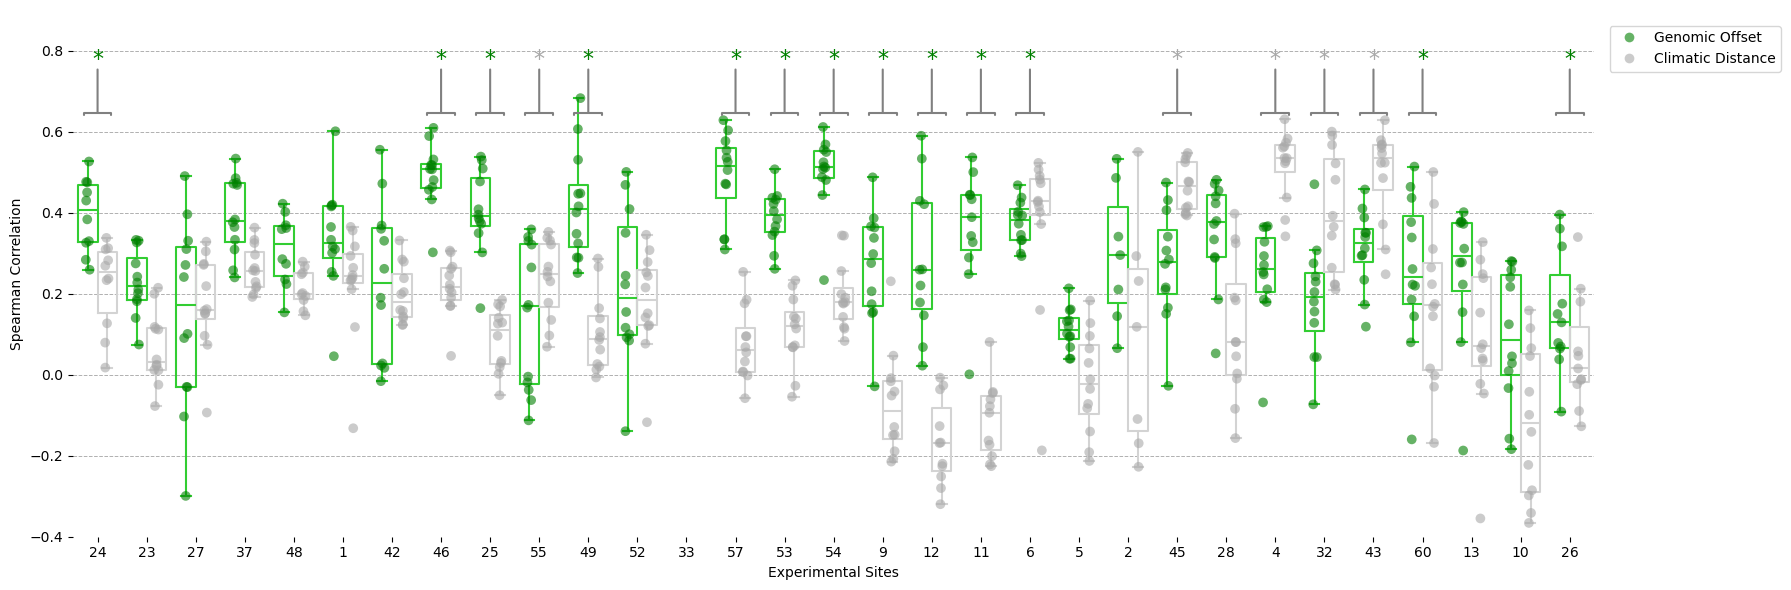

In [187]:
variable = 'kendall_tau'
order_touse = sort_bio1
s_value = 7
alpha_value = 0.6 
# Define a custom color palette mapping each dataset to a specific color
palette_stripplot = {
    'climatic_distance': 'darkgrey',  # Light green
    'genomic_offset': 'green',     # Dark green
    'climatic_distance_model': 'grey',  # Lime green
    'baseline_pairwise_samples': 'black' # Forest green
}

palette_boxplot = {
    'climatic_distance': 'lightgrey',  # Light green
    'genomic_offset': '#32CD32',     # Dark green
    'climatic_distance_model': 'grey',  # Lime green
    'baseline_pairwise_samples': 'black' # Forest green

}


# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = results.groupby('site')[variable].mean().sort_values()

#combined_results.
# Create 4 subplots (4 rows, 1 column)
fig, ax = plt.subplots(figsize=(18, 6))

# Plot 2: 'climatic distance' and 'genomi_offset'
stripplot = sns.stripplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'genomic_offset'])], order=order_touse,s=s_value,alpha=alpha_value,
            y=variable, x='site', hue='dataset', palette=palette_stripplot, dodge=True)

box_plot = sns.boxplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'genomic_offset'])], 
                       order=sort_bio1.astype(int), y=variable, x='site', 
                       hue='dataset',fill=False,
                       showfliers=False, palette=palette_boxplot,
                      legend= False)


# Add stars for statistical significance and color them based on which one is higher
for site in test_results:
    p_value = test_results[site].pvalue
    if p_value < 0.05:
        x_position = list(order_touse.astype(int)).index(site)
        y_max = combined_results[combined_results['site'] == site][variable].max()
        site_data = merged_data[merged_data['site'] == site]
        genomic_mean = site_data[variable + '_geno'].mean()
        climatic_mean = site_data[variable + '_clim'].mean()
        
        if genomic_mean > climatic_mean:
            star_color = 'green'  # Green if genomic offset is higher
        else:
            star_color = 'darkgrey'  # Grey if climatic distance is higher

        ymax = 0.7
        # Add stars for significance with the appropriate color
        ax.text(x_position, ymax + 0.05, "*", ha='center', va='bottom', color=star_color, fontsize=16)

        # Add horizontal bracket (bracket over the comparison)
        ax.annotate('', xy=(x_position,ymax + 0.06), xycoords='data',
                    xytext=(x_position, ymax - 0.06), textcoords='data',
                    arrowprops={'arrowstyle': ']-', 'color': 'grey', 'linewidth': 1.5})

ax.grid(axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7)
# Customizing the legend to show only stripplot legend items
# Customizing the legend to show only stripplot legend items
handles, labels = ax.get_legend_handles_labels()
legend_handles = handles[:len(stripplot.get_legend_handles_labels()[0])]  # Keep only stripplot legend handles
legend_labels = ['Genomic Offset', 'Climatic Distance']  # Custom legend labels

# Adding the filtered legend back to the plot
ax.legend(legend_handles, legend_labels, bbox_to_anchor=(1.01, 0.97), loc='upper left', borderaxespad=0.)
ax.set_ylim(-0.4, 0.9)  

ax.set_xlabel('Experimental Sites')
ax.set_ylabel('Spearman Correlation')
# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


In [177]:
variable = 'top_30'
from scipy.stats import ttest_rel, wilcoxon

# To store the p-values
test_results = {}

for site in combined_results['site'].unique():
    
    site_data = combined_results[combined_results['site'] == site]    
    clim = site_data[site_data['dataset'] == 'climatic_distance'][variable] 
    geno = site_data[site_data['dataset'] == 'genomic_offset'][variable]
    # If not normally distributed, use Wilcoxon signed-rank test
    test_results[site] = wilcoxon(geno, clim)

/carnegie/hpcdata/software/conda/envs/python-3.11/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/carnegie/hpcdata/software/conda/envs/python-3.11/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [178]:
combined_results

index  sp_correlation  pearsonr  r_squared  kendall_tau  top_10  \
0       1_2_2        0.595953  0.155653   0.024228     0.419462    20.0   
1       1_2_3        0.590153  0.074691   0.005579     0.417655    10.0   
2       1_3_1        0.457090  0.072165   0.005208     0.310001    10.0   
3       1_3_4        0.080791 -0.009302   0.000087     0.045505     0.0   
4       1_3_5        0.442595  0.107687   0.011597     0.300640    10.0   
...       ...             ...       ...        ...          ...     ...   
2920   60_1_8        0.437185  0.120607   0.014546     0.291766    10.0   
2921   60_1_9        0.120858  0.069203   0.004789     0.082447    10.0   
2922  60_1_10        0.321997  0.197681   0.039078     0.222536    30.0   
2923  60_1_11        0.386155  0.227219   0.051628     0.268620    10.0   
2924  60_1_12        0.328359  0.159667   0.025494     0.227773    20.0   

      top_20     top_30  top_40  top_50     top_60  top_100  site plot  \
0       15.0  26.666667    37.5    34.0  35.000000     66.0     1    2   
1       15.0  16.666667    25.0    34.0  36.666667     66.0     1    3   
2        5.0  16.666667    27.5    28.0  36.666667     58.0     1    1   
3       10.0  10.000000    12.5    14.0  18.333333     38.0     1    4   
4        5.0  10.000000    22.5    22.0  35.000000     61.0     1    5   
...      ...        ...     ...     ...        ...      ...   ...  ...   
2920    15.0  26.666667    30.0    30.0        NaN      NaN    60    8   
2921    10.0  16.666667    17.5    28.0        NaN      NaN    60    9   
2922    25.0  20.000000    25.0    30.0        NaN      NaN    60   10   
2923    30.0  26.666667    32.5    42.0        NaN      NaN    60   11   
2924    40.0  30.000000    35.0    40.0        NaN      NaN    60   12   

                      dataset  level_0 samples  
0              genomic_offset      NaN     NaN  
1              genomic_offset      NaN     NaN  
2              genomic_offset      NaN     NaN  
3              genomic_offset      NaN     NaN  
4              genomic_offset      NaN     NaN  
...                       ...      ...     ...  
2920  climatic_distance_model      NaN     NaN  
2921  climatic_distance_model      NaN     NaN  
2922  climatic_distance_model      NaN     NaN  
2923  climatic_distance_model      NaN     NaN  
2924  climatic_distance_model      NaN     NaN  

[2925 rows x 17 columns]

In [139]:



  # This will give you the p-values for each sit

In [70]:
clim['sp_correlation']

index  sp_correlation  pearsonr  r_squared  kendall_tau  top_10  \
684   60_1_1        0.559141  0.035885   0.001288     0.421423    10.0   
685   60_1_2       -0.004921  0.016757   0.000281    -0.002172     0.0   
686   60_1_3        0.310729  0.140367   0.019703     0.223206    20.0   
687   60_1_4        0.216072  0.041764   0.001744     0.144143    10.0   
688   60_1_5        0.369834  0.044592   0.001988     0.264381     0.0   
689   60_1_6       -0.048594 -0.009748   0.000095    -0.029789     0.0   
690   60_1_7       -0.250938 -0.022412   0.000502    -0.168697    10.0   
691   60_1_8        0.251909  0.015499   0.000240     0.174604     0.0   
692   60_1_9        0.045511  0.010238   0.000105     0.015553     0.0   
693  60_1_10        0.233987  0.071336   0.005089     0.167731     0.0   
694  60_1_11        0.643584  0.162564   0.026427     0.500212    10.0   
695  60_1_12        0.451116  0.127249   0.016192     0.310198    10.0   

     top_20     top_30  top_40  top_50  top_60  top_100  site plot  \
684    35.0  53.333333    55.0    56.0     NaN      NaN    60    1   
685     5.0  10.000000    12.5    20.0     NaN      NaN    60    2   
686    30.0  36.666667    37.5    38.0     NaN      NaN    60    3   
687    30.0  36.666667    40.0    34.0     NaN      NaN    60    4   
688    10.0  20.000000    32.5    36.0     NaN      NaN    60    5   
689    15.0  20.000000    20.0    28.0     NaN      NaN    60    6   
690    15.0  10.000000     7.5     8.0     NaN      NaN    60    7   
691    20.0  30.000000    30.0    30.0     NaN      NaN    60    8   
692    15.0  23.333333    20.0    28.0     NaN      NaN    60    9   
693    10.0  26.666667    25.0    26.0     NaN      NaN    60   10   
694    40.0  63.333333    65.0    66.0     NaN      NaN    60   11   
695    20.0  26.666667    32.5    40.0     NaN      NaN    60   12   

               dataset  level_0 samples  
684  climatic_distance    336.0     NaN  
685  climatic_distance    337.0     NaN  
686  climatic_distance    338.0     NaN  
687  climatic_distance    339.0     NaN  
688  climatic_distance    340.0     NaN  
689  climatic_distance    341.0     NaN  
690  climatic_distance    342.0     NaN  
691  climatic_distance    343.0     NaN  
692  climatic_distance    344.0     NaN  
693  climatic_distance    345.0     NaN  
694  climatic_distance    346.0     NaN  
695  climatic_distance    347.0     NaN

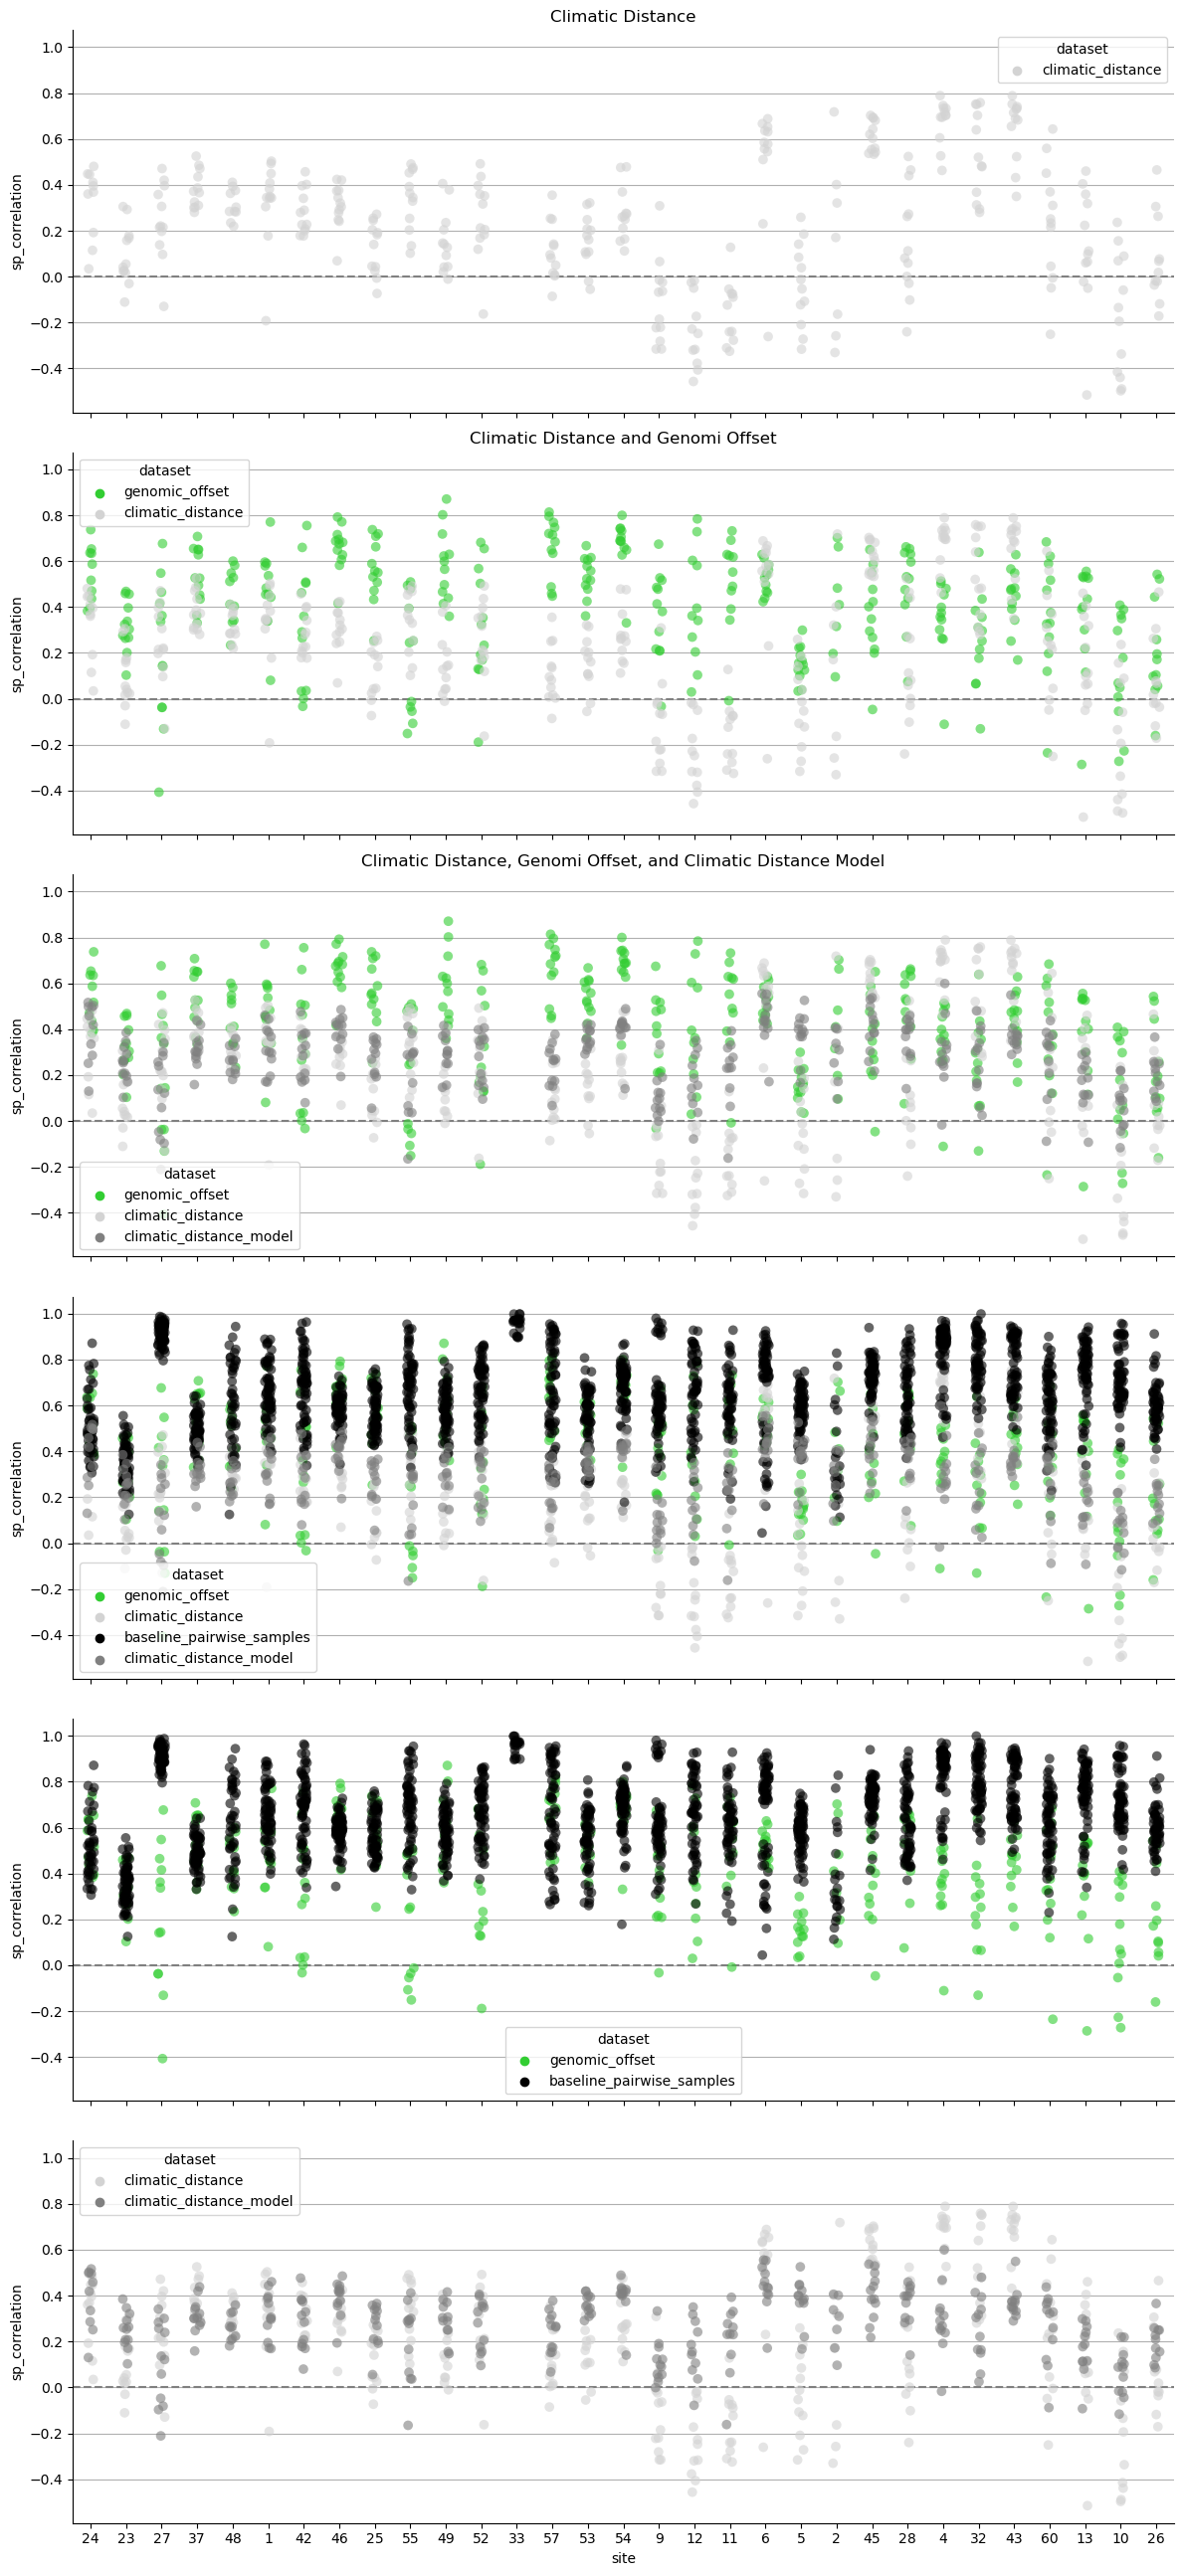

In [29]:
variable = 'sp_correlation'
order_touse = sort_bio1
s_value = 7
alpha_value = 0.6 
# Define a custom color palette mapping each dataset to a specific color
palette = {
    'climatic_distance': 'lightgrey',  # Light green
    'genomic_offset': '#32CD32',     # Dark green
    'climatic_distance_model': 'grey',  # Lime green
    'baseline_pairwise_samples': 'black' # Forest green
}

#combined_results.
# Create 4 subplots (4 rows, 1 column)
fig, axes = plt.subplots(6, 1, figsize=(12, 26), sharex=True, sharey=True)

# Plot 1: Only 'climatic distance'
sns.stripplot(data=combined_results[combined_results['dataset'] == 'climatic_distance'], order=order_touse,s=s_value,alpha=alpha_value,
            y=variable, x='site', hue='dataset', ax=axes[0], palette=palette)
axes[0].axhline(0, color='grey', linestyle='--')
axes[0].set_title('Climatic Distance')

# Plot 2: 'climatic distance' and 'genomi_offset'
sns.stripplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'genomic_offset'])], order=order_touse,s=s_value,alpha=alpha_value,
            y=variable, x='site', hue='dataset', ax=axes[1], palette=palette)
axes[1].axhline(0, color='grey', linestyle='--')
axes[1].set_title('Climatic Distance and Genomi Offset')

# Plot 3: 'climatic distance', 'genomi_offset', and 'climatic_dsitance model'
sns.stripplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'genomic_offset', 'climatic_distance_model'])], order=order_touse,s=s_value,alpha=alpha_value,
            y=variable, x='site', hue='dataset', ax=axes[2], palette=palette)
axes[2].axhline(0, color='grey', linestyle='--')
axes[2].set_title('Climatic Distance, Genomi Offset, and Climatic Distance Model')

# Plot 4: All datasets
sns.stripplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'genomic_offset', 'climatic_distance_model', 'baseline_pairwise_samples'])],s=s_value,alpha=alpha_value,
            y=variable, x='site', hue='dataset', order=order_touse, ax=axes[3], palette=palette)
axes[3].axhline(0, color='grey', linestyle='--')


# Plot 4: All datasets
sns.stripplot(data=combined_results[combined_results['dataset'].isin(['baseline_pairwise_samples', 'genomic_offset'])],s=s_value,alpha=alpha_value,
            y=variable, x='site', hue='dataset', order=order_touse, ax=axes[4], palette=palette)
axes[4].axhline(0, color='grey', linestyle='--')


# Plot 4: All datasets
sns.stripplot(data=combined_results[combined_results['dataset'].isin(['climatic_distance', 'climatic_distance_model'])],s=s_value,alpha=alpha_value,
            y=variable, x='site', hue='dataset', order=order_touse, ax=axes[5], palette=palette)
axes[5].axhline(0, color='grey', linestyle='--')


# Set common properties
for ax in axes.flat:
    ax.grid(axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


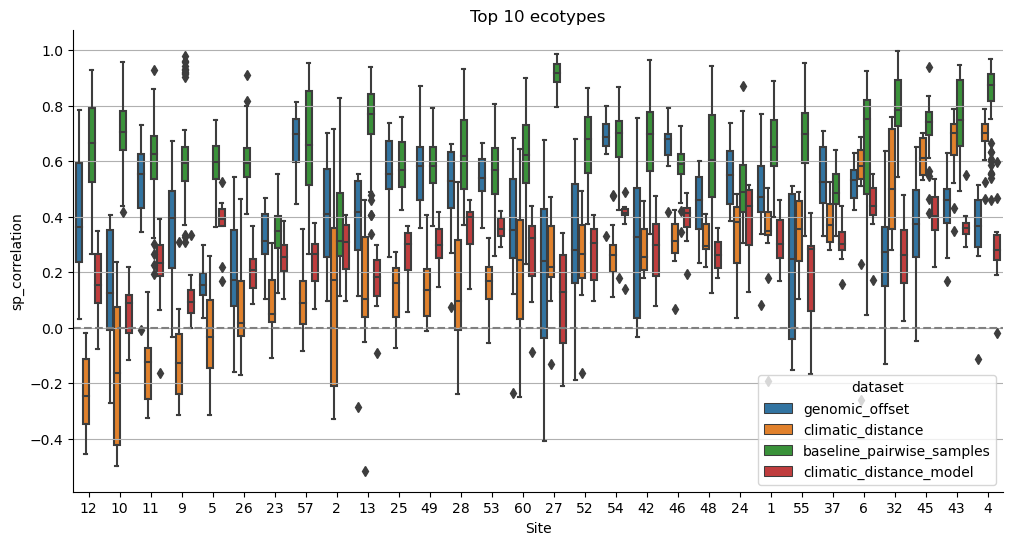

In [1420]:
# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = cd_results.groupby('site')['sp_correlation'].mean().sort_values()

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.boxplot(data=combined_results, y='sp_correlation', x='site', hue='dataset', order=medians_results.index)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')

# Add labels and title
plt.title('Top 10 ecotypes')

# Display the plot
plt.show()

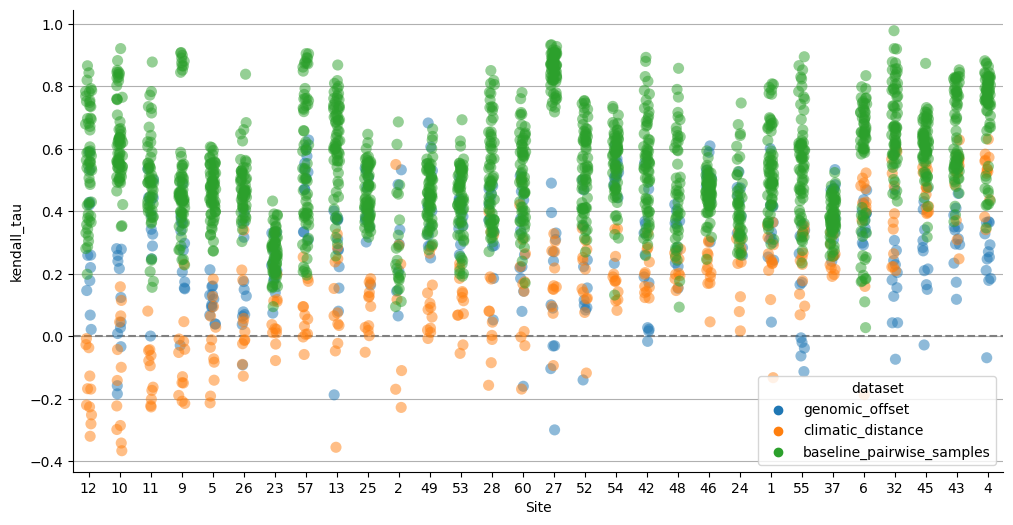

In [1386]:
# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = cd_results.groupby('site')['kendall_tau'].mean().sort_values()

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.stripplot(data=combined_results, y='kendall_tau', x='site', hue='dataset', order=medians_results.index.astype(str), s=8, alpha = 0.5)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')

# Display the plot
plt.show()

In [1260]:
combined_results

index  sp_correlation  pearsonr  r_squared  kendall_tau  top_10  top_20  \
0     1_2_2        0.595953  0.155653   0.024228     0.419462    20.0    15.0   
1     1_2_3        0.590153  0.074691   0.005579     0.417655    10.0    15.0   
2     1_3_1        0.457090  0.072165   0.005208     0.310001    10.0     5.0   
3     1_3_4        0.080791 -0.009302   0.000087     0.045505     0.0    10.0   
4     1_3_5        0.442595  0.107687   0.011597     0.300640    10.0     5.0   
...     ...             ...       ...        ...          ...     ...     ...   
1876    NaN        0.783460  0.399482   0.159586     0.627931    20.0    40.0   
1877    NaN        0.609095 -0.022335   0.000499     0.457453     0.0    15.0   
1878    NaN        0.736136  0.083087   0.006904     0.643490    10.0    25.0   
1879    NaN        0.659067  0.034134   0.001165     0.519764     0.0    10.0   
1880    NaN        0.758910  0.011356   0.000129     0.625647    10.0    35.0   

         top_30  top_40  top_50     top_60  top_100  site plot  \
0     26.666667    37.5    34.0  35.000000     66.0     1    2   
1     16.666667    25.0    34.0  36.666667     66.0     1    3   
2     16.666667    27.5    28.0  36.666667     58.0     1    1   
3     10.000000    12.5    14.0  18.333333     38.0     1    4   
4     10.000000    22.5    22.0  35.000000     61.0     1    5   
...         ...     ...     ...        ...      ...   ...  ...   
1876  43.333333    57.5    60.0  63.333333     81.0    60  NaN   
1877  26.666667    37.5    54.0  60.000000     72.0    60  NaN   
1878  43.333333    55.0    62.0  70.000000     85.0    60  NaN   
1879  33.333333    45.0    58.0  63.333333     80.0    60  NaN   
1880  46.666667    55.0    68.0  73.333333     81.0    60  NaN   

                        dataset  level_0          samples  
0                genomic_offset      NaN              NaN  
1                genomic_offset      NaN              NaN  
2                genomic_offset      NaN              NaN  
3                genomic_offset      NaN              NaN  
4                genomic_offset      NaN              NaN  
...                         ...      ...              ...  
1876  baseline_pairwise_samples      NaN   60_1_9-60_1_11  
1877  baseline_pairwise_samples      NaN   60_1_9-60_1_12  
1878  baseline_pairwise_samples      NaN  60_1_10-60_1_11  
1879  baseline_pairwise_samples      NaN  60_1_10-60_1_12  
1880  baseline_pairwise_samples      NaN  60_1_11-60_1_12  

[2577 rows x 17 columns]

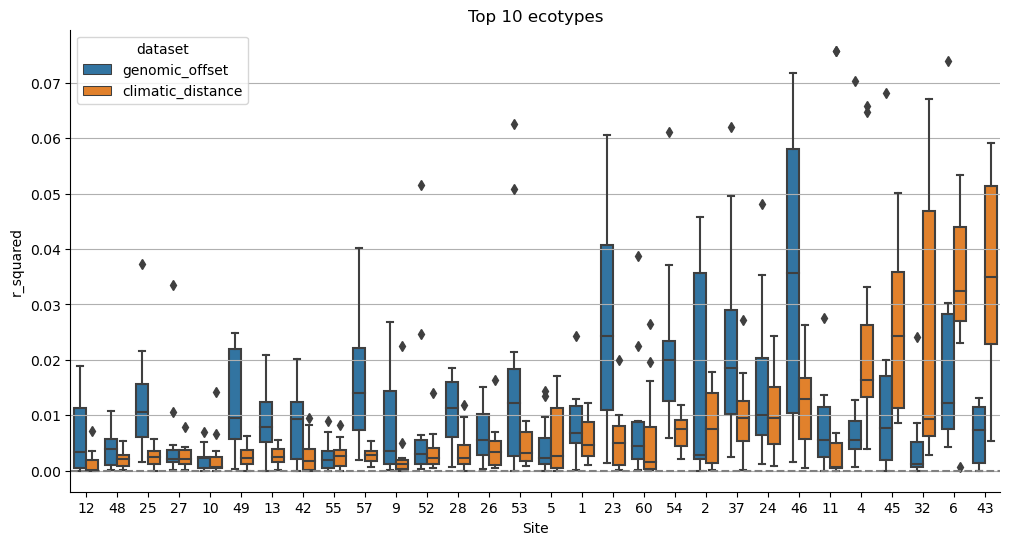

In [1263]:
# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = cd_results.groupby('site')['r_squared'].mean().sort_values()

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.boxplot(data=combined_results[combined_results['dataset']!= 'baseline_pairwise_samples'], y='r_squared', x='site', hue='dataset', order=medians_results.index)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')

# Add labels and title
plt.title('Top 10 ecotypes')

# Display the plot
plt.show()

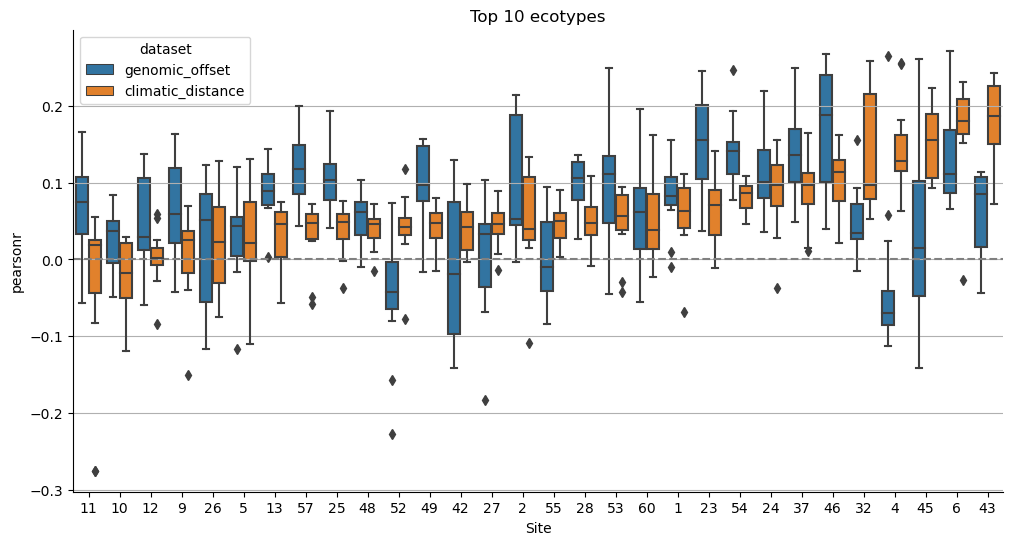

In [1262]:
# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = cd_results.groupby('site')['pearsonr'].mean().sort_values()

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.boxplot(data=combined_results[combined_results['dataset']!= 'baseline_pairwise_samples'], y='pearsonr', x='site', hue='dataset', order=medians_results.index)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')

# Add labels and title
plt.title('Top 10 ecotypes')

# Display the plot
plt.show()

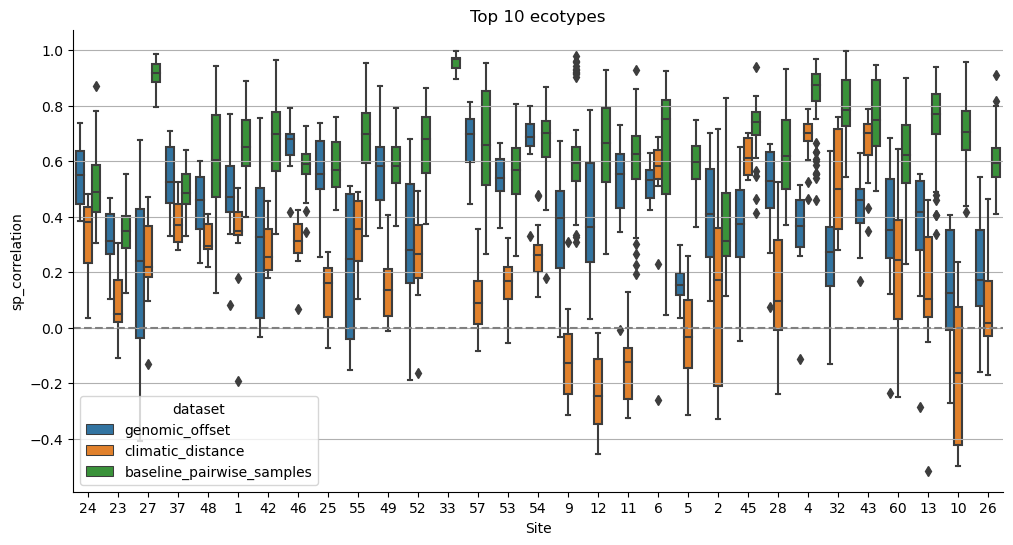

In [1387]:
# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = cd_results.groupby('site')['sp_correlation'].mean().sort_values()

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.boxplot(data=combined_results, y='sp_correlation', x='site', hue='dataset', order=sort_bio1)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')

# Add labels and title
plt.title('Top 10 ecotypes')

# Display the plot
plt.show()

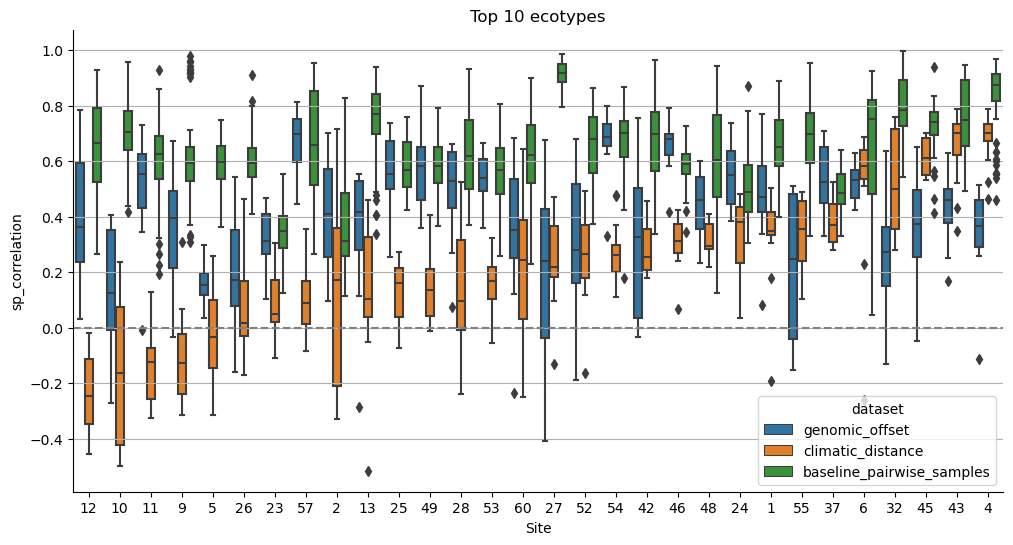

In [1381]:
# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = cd_results.groupby('site')['sp_correlation'].mean().sort_values()

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.boxplot(data=combined_results, y='sp_correlation', x='site', hue='dataset', order=medians_results.index.astype(str))

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')

# Add labels and title
plt.title('Top 10 ecotypes')

# Display the plot
plt.show()

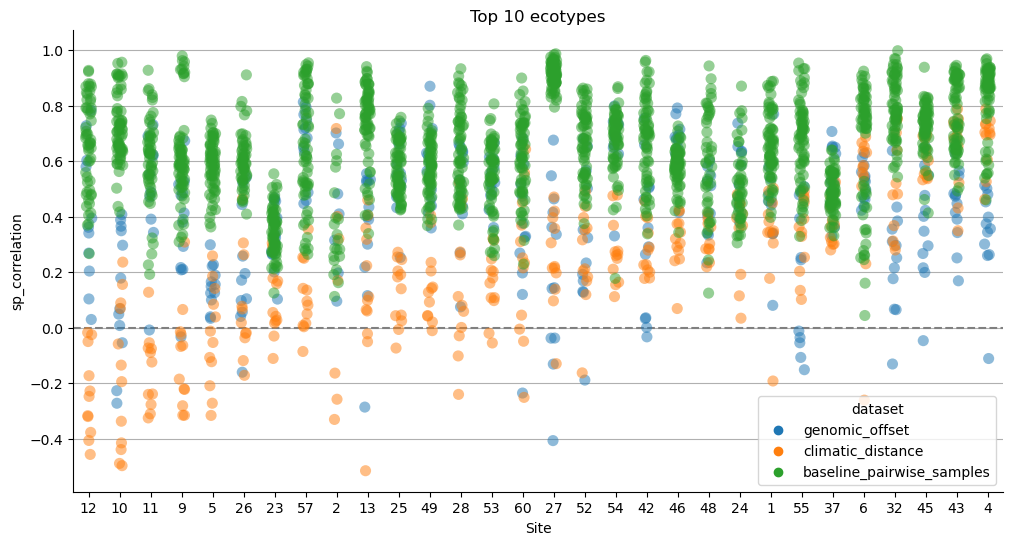

In [1385]:
# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = cd_results.groupby('site')['sp_correlation'].mean().sort_values()

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.stripplot(data=combined_results, y='sp_correlation', x='site', hue='dataset', order=medians_results.index.astype(str), s=8, alpha = 0.5)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')

# Display the plot
plt.show()

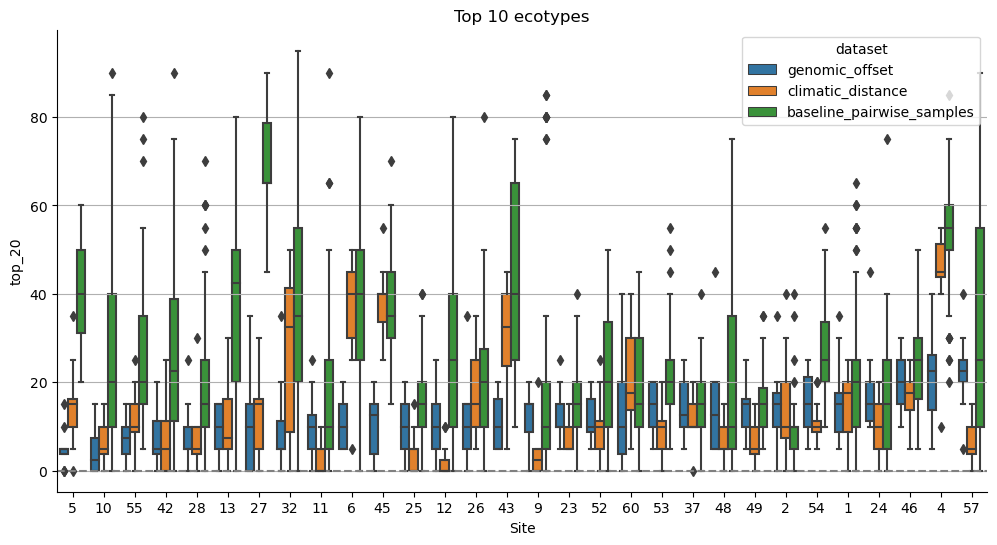

In [1257]:
# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = results.groupby('site')['top_20'].mean().sort_values()

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.boxplot(data=combined_results, y='top_20', x='site', hue='dataset', order=medians_results.index)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')

# Add labels and title
plt.title('Top 10 ecotypes')

# Display the plot
plt.show()

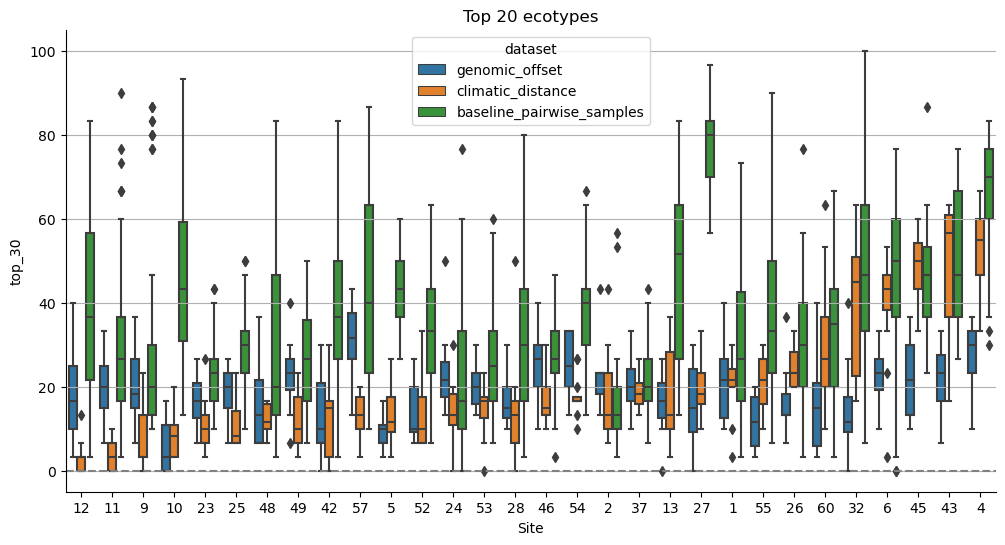

In [1258]:
# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = cd_results.groupby('site')['top_30'].mean().sort_values()

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.boxplot(data=combined_results, y='top_30', x='site', hue='dataset', order=medians_results.index)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')
plt.title('Top 20 ecotypes')

# Display the plot
plt.show()

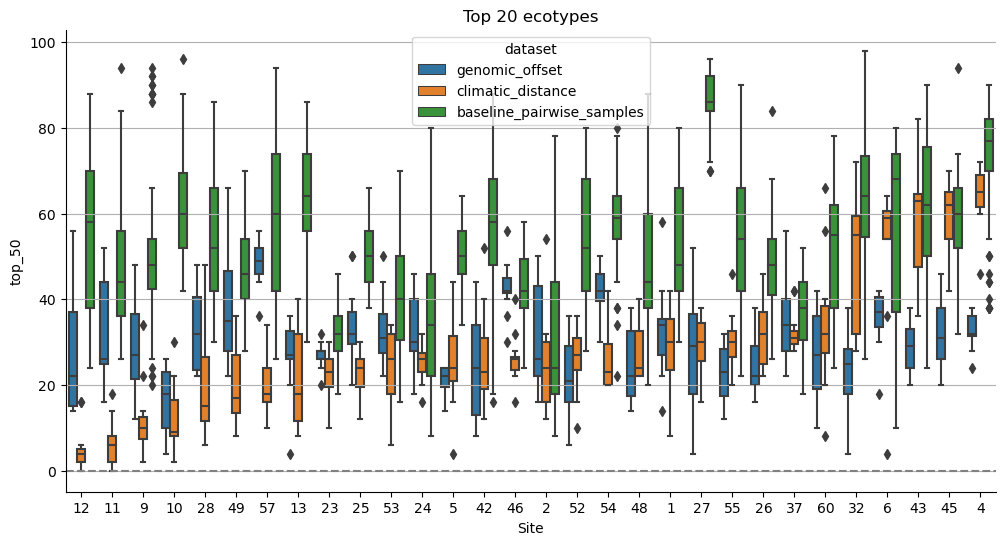

In [1259]:
# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = cd_results.groupby('site')['top_50'].mean().sort_values()

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.boxplot(data=combined_results, y='top_50', x='site', hue='dataset', order=medians_results.index)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')
plt.title('Top 20 ecotypes')


# Display the plot
plt.show()

In [1378]:
medians_results.index.astype(str)

Index(['12', '11', '9', '10', '28', '49', '57', '13', '23', '25', '53', '24',
       '5', '42', '46', '2', '52', '54', '48', '1', '27', '55', '26', '37',
       '60', '32', '6', '43', '45', '4'],
      dtype='object', name='site')

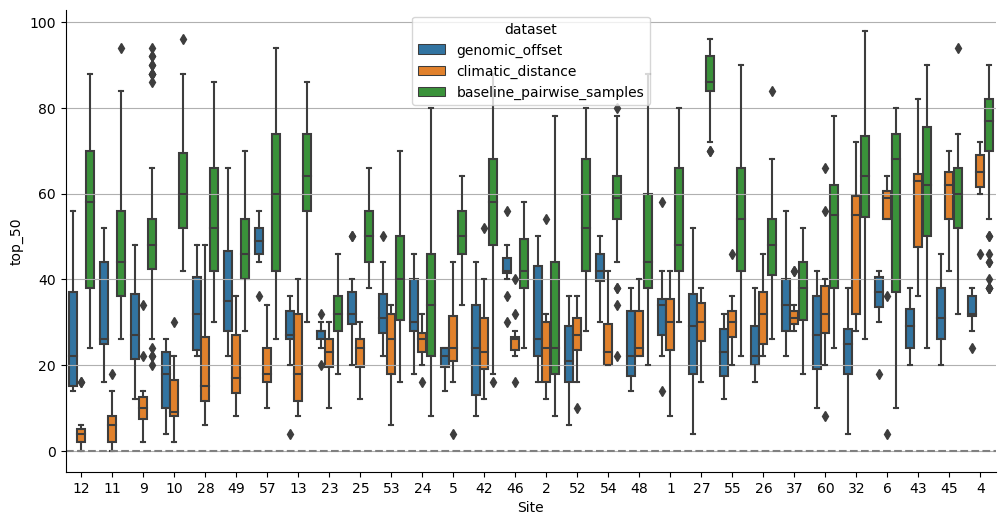

In [1379]:
# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = cd_results.groupby('site')['top_50'].mean().sort_values()

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.boxplot(data=combined_results, y='top_50', x='site', hue='dataset', order=medians_results.index.astype(str))

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')

# Display the plot
plt.show()

In [1279]:
medians_results = cd_results.groupby('site')['top_50'].mean().sort_values()

In [1280]:
order_str = [str(i) for i in medians_results.index]

In [1342]:
combined_results['site'] = combined_results['site'].astype(str)

In [1348]:
# Define the order as string for the 'site' column
order_str = ['12', '11', '9', '10', '28', '49', '57', '13', '23', '25', '53', '24', '5', '42', '46', '2', 
             '52', '54', '48', '1', '27', '55', '26', '37', '60', '32', '6', '43', '45', '4']



In [ ]:
# Set the size of the plot
plt.figure(figsize=(25, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.stripplot(data=combined_results, y='top_50', x='site', hue='dataset', alpha = .5, order=order_str)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')

# Display the plot
plt.show()

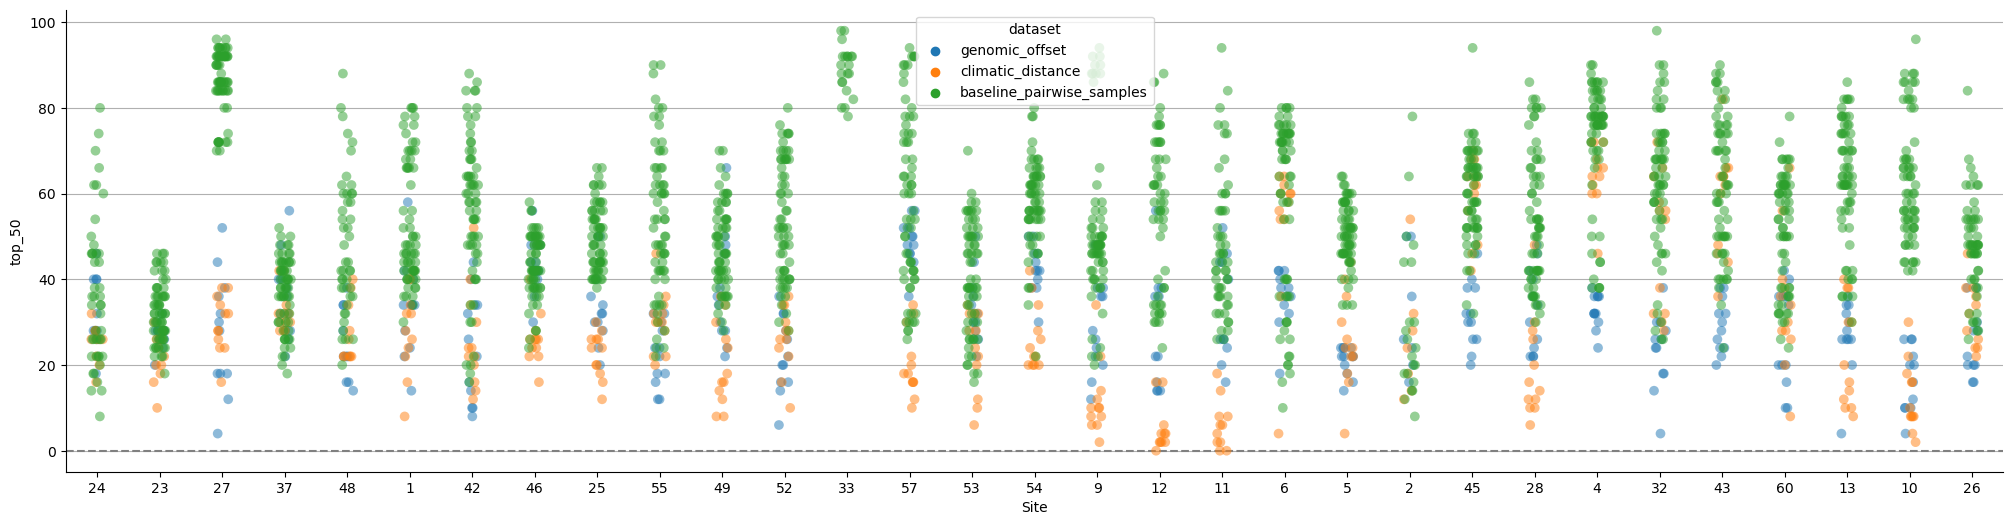

In [1374]:
# Set the size of the plot
plt.figure(figsize=(25, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.stripplot(data=combined_results, y='top_50', x='site', hue='dataset', alpha = .5, order=sort_bio1, s= 7)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')

# Display the plot
plt.show()

/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 17.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripp

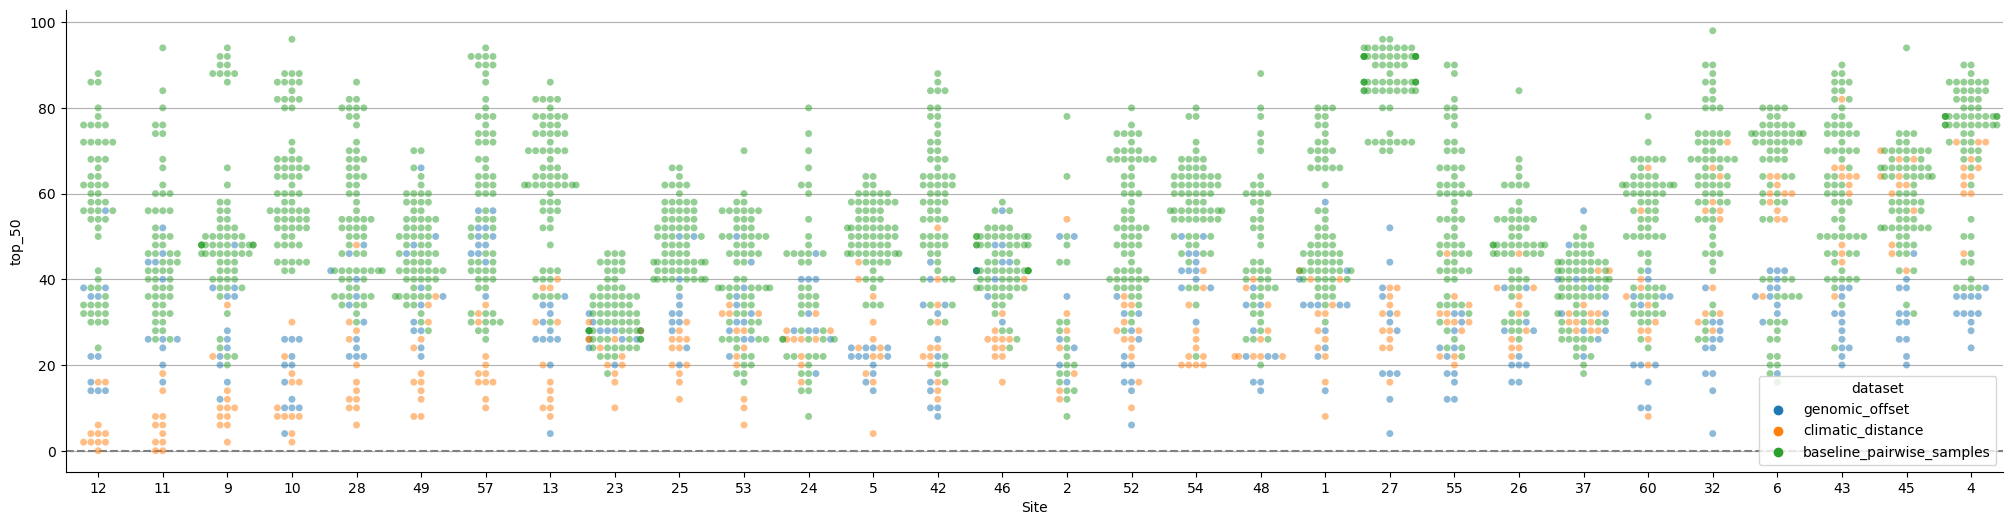

In [1351]:
# Set the size of the plot
plt.figure(figsize=(25, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.swarmplot(data=combined_results, y='top_50', x='site', hue='dataset', alpha = .5, order=order_str)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')

# Display the plot
plt.show()

In [ ]:
combined_results_new = pd.read_csv('chat.csv')

# Convert the 'site' column to string and apply the order again for the new dataset
combined_results_new['site'] = combined_results_new['site'].astype(str)

# Define the order as string for the 'site' column
order_str = ['12', '11', '9', '10', '28', '49', '57', '13', '23', '25', '53', '24', '5', '42', '46', '2', 
             '52', '54', '48', '1', '27', '55', '26', '37', '60', '32', '6', '43', '45', '4']

# Create the swarm plot
plt.figure(figsize=(12, 6))
sns.swarmplot(data=combined_results_new, y='top_50', x='site', hue='dataset', alpha=0.5, order=order_str)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')
plt.title('Top 50 Ecotypes by Site')

# Display the plot
plt.show()

In [266]:
results.columns

Index(['index', 'sp_correlation', 'pearsonr', 'r_squared', 'site', 'plot'], dtype='object')

In [28]:
results['site'] = results['site'].astype(int)

In [268]:
combined_results.groupby('dataset')['sp_correlation'].mean()

dataset
results      -0.018497
results_cd    0.255623
Name: sp_correlation, dtype: float64

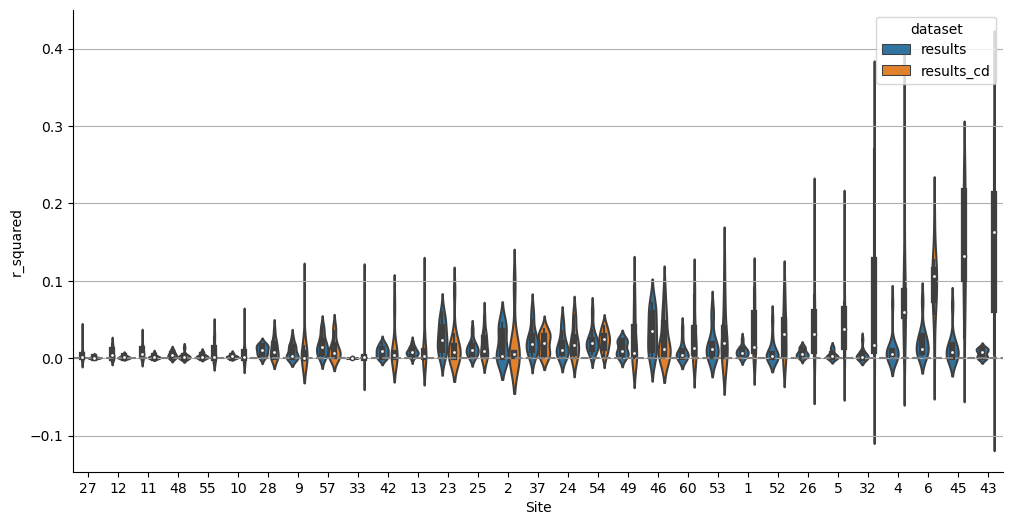

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add a new column to differentiate between the two DataFrames
results['dataset'] = 'results'
cd_results['dataset'] = 'results_cd'

# Concatenate the two DataFrames
combined_results = pd.concat([results, cd_results])

# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = cd_results.groupby('site')['r_squared'].mean().sort_values()

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.violinplot(data=combined_results, y='r_squared', x='site', hue='dataset', order=medians_results.index)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')

# Display the plot
plt.show()


In [271]:
combined_results.groupby('dataset')['sp_correlation'].mean()

dataset
results       0.403035
results_cd    0.255623
Name: sp_correlation, dtype: float64

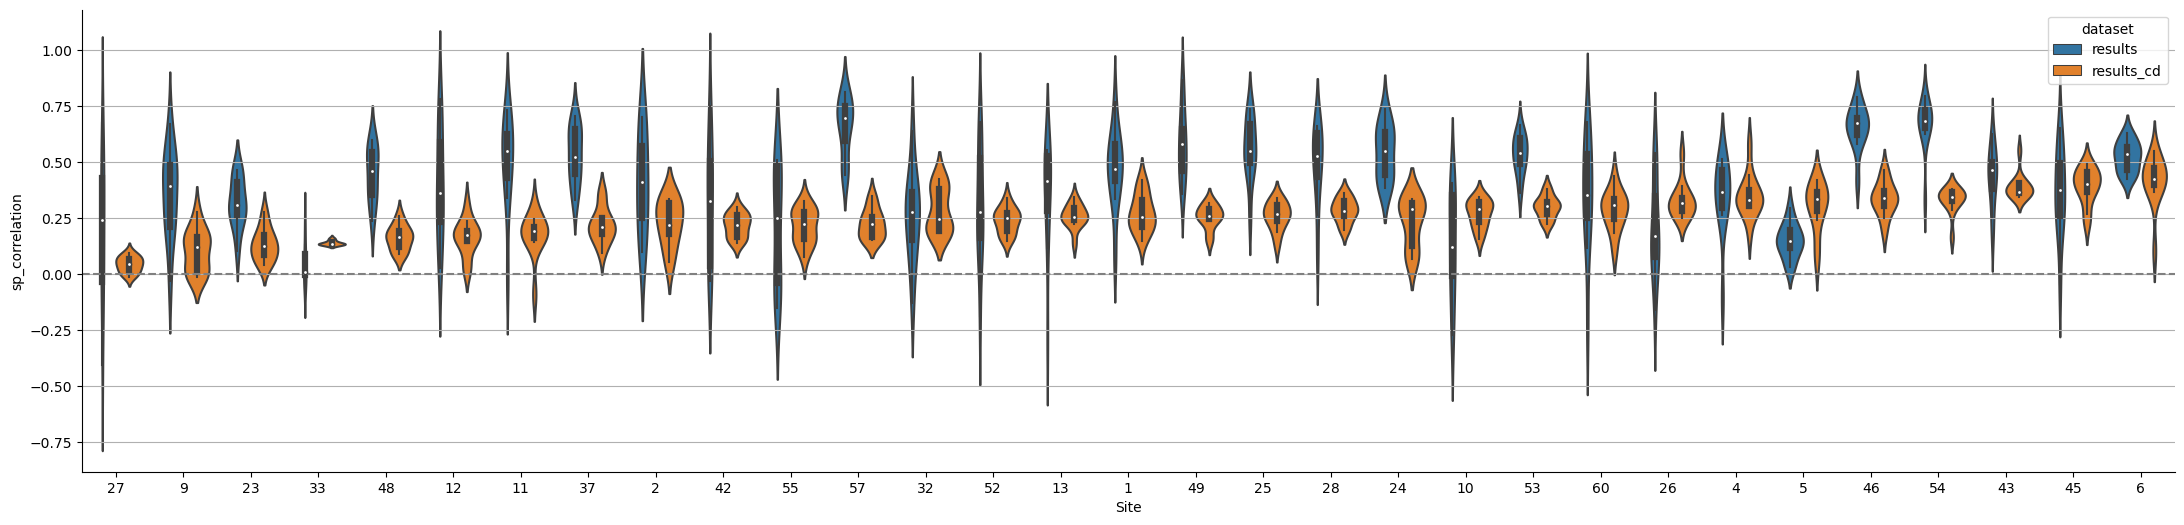

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add a new column to differentiate between the two DataFrames
results['dataset'] = 'results'
cd_results['dataset'] = 'results_cd'

# Concatenate the two DataFrames
combined_results = pd.concat([results, cd_results])

# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = cd_results.groupby('site')['sp_correlation'].median().sort_values()

# Set the size of the plot
plt.figure(figsize=(27, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.violinplot(data=combined_results, y='sp_correlation', x='site', hue='dataset', order=medians_results.index)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')

# Display the plot
plt.show()


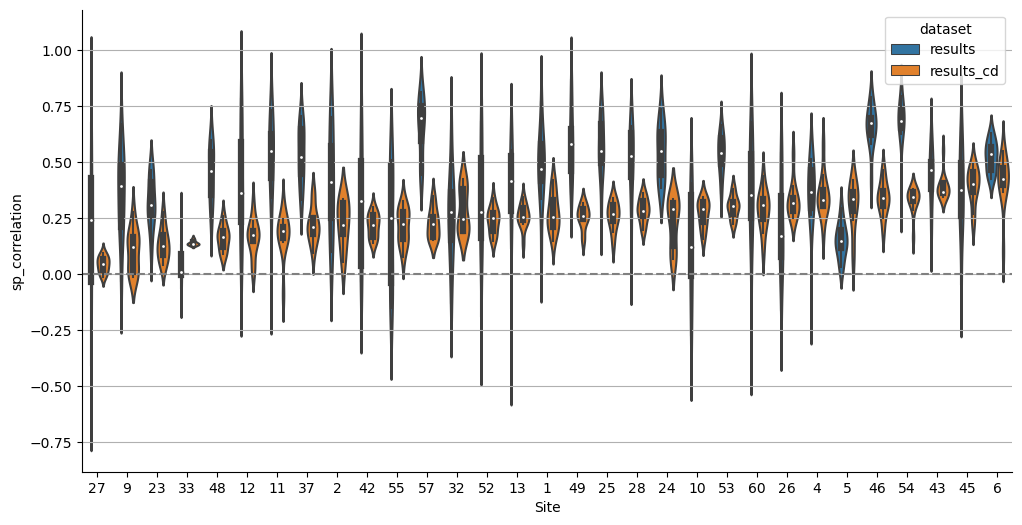

In [272]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add a new column to differentiate between the two DataFrames
results['dataset'] = 'results'
cd_results['dataset'] = 'results_cd'

# Concatenate the two DataFrames
combined_results = pd.concat([results, cd_results])

# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = cd_results.groupby('site')['sp_correlation'].median().sort_values()

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.violinplot(data=combined_results, y='sp_correlation', x='site', hue='dataset', order=medians_results.index)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')

# Display the plot
plt.show()


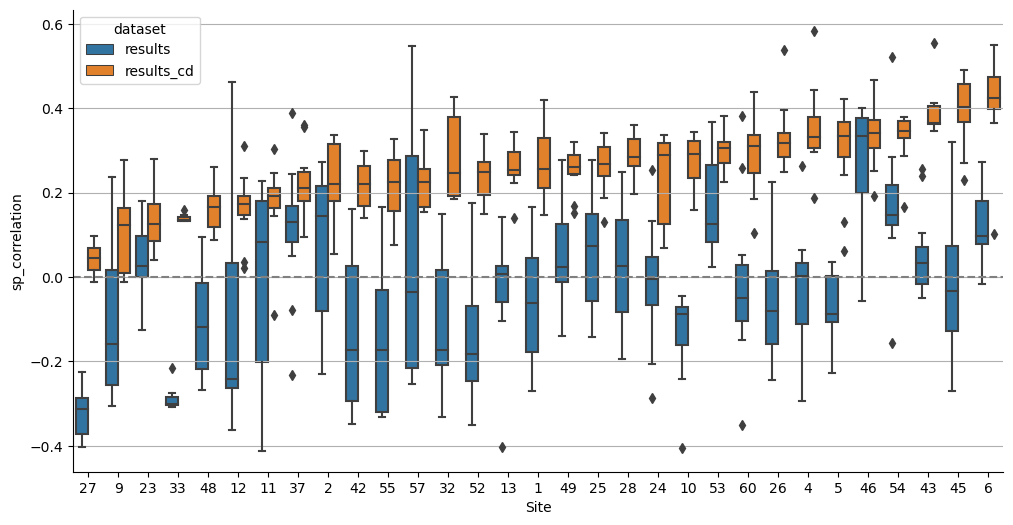

In [252]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add a new column to differentiate between the two DataFrames
results['dataset'] = 'results'
cd_results['dataset'] = 'results_cd'

# Concatenate the two DataFrames
combined_results = pd.concat([results, cd_results])

# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = cd_results.groupby('site')['sp_correlation'].median().sort_values()

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.boxplot(data=combined_results, y='sp_correlation', x='site', hue='dataset', order=medians_results.index)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Site')

# Display the plot
plt.show()

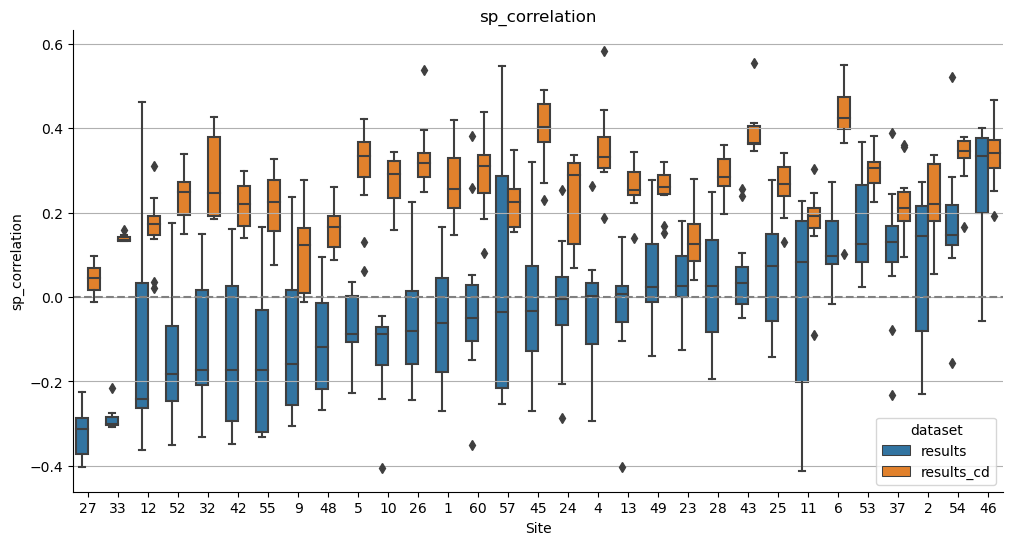

In [253]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add a new column to differentiate between the two DataFrames
results['dataset'] = 'results'
cd_results['dataset'] = 'results_cd'

# Concatenate the two DataFrames
combined_results = pd.concat([results, cd_results])

# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = results.groupby('site')['sp_correlation'].median().sort_values()

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.boxplot(data=combined_results, y='sp_correlation', x='site', hue='dataset', order=medians_results.index)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.title('sp_correlation')
plt.xlabel('Site')
plt.ylabel('sp_correlation')

# Display the plot
plt.show()


/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


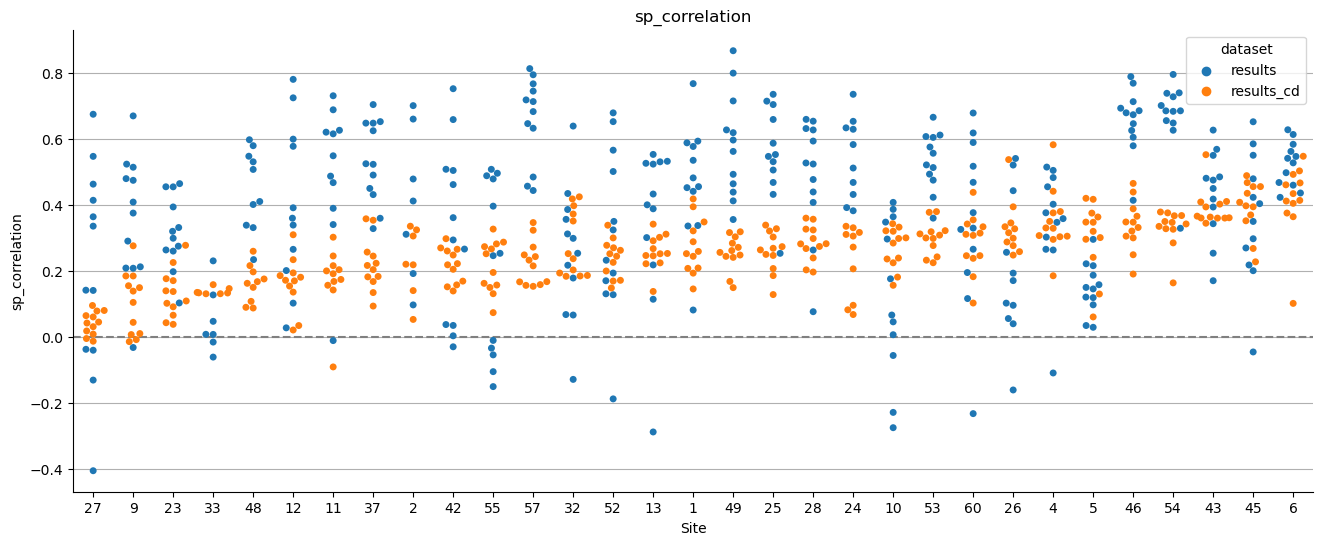

In [273]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add a new column to differentiate between the two DataFrames
results['dataset'] = 'results'
cd_results['dataset'] = 'results_cd'

# Concatenate the two DataFrames
combined_results = pd.concat([results, cd_results])

# Calculate medians of 'sp_correlation' for 'results' only to determine the order
medians_results = cd_results.groupby('site')['sp_correlation'].median().sort_values()

# Set the size of the plot
plt.figure(figsize=(16, 6))

# Create the violin plot, using 'hue' to distinguish between 'results' and 'results_cd'
sns.swarmplot(data=combined_results, y='sp_correlation', x='site', hue='dataset', order=medians_results.index)

# Draw a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Grid and spine settings
plt.grid(axis='y')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.title('sp_correlation')
plt.xlabel('Site')
plt.ylabel('sp_correlation')

# Display the plot
plt.show()


In [66]:
conc = pd.concat([ef_f, cd],axis=1)

In [67]:
conc

1_2_2         1
0   -0.004564       NaN
1   -0.002939       NaN
2   -0.002825       NaN
3   -0.003645       NaN
4   -0.003877       NaN
..        ...       ...
226       NaN  0.314736
227       NaN  0.263432
228       NaN  0.267499
229       NaN  0.267906
230       NaN  0.261544

[462 rows x 2 columns]

In [16]:
import os
import pickle

In [17]:
files = os.listdir('../baypass_lastgen/individual_gfiles_last_gen/')

partitions = [int(file.split('_')[1].replace('.txt', '')) for file in files if '.txt' in file]

In [18]:
partitions_r = {}
for i in range(len(partitions)):
    pickle_file_path = f'../baypass_lastgen/individual_gfiles_last_gen/loci_partition_{i}'
    with open(pickle_file_path, 'rb') as file:
        loci_f = pickle.load(file)
    results = pd.read_csv(f'results/partition{i}.csv')
    results['snp_id'] = loci_f
    partitions_r[i] = results
results = pd.concat(partitions_r).reset_index(drop=True)
#results.to_csv(f'results/split_{split}/binomial_reg_results_last_gen.csv',index=None)

In [22]:
snp_origin_bio1 = pd.read_csv('../key_files/snp_origin_bio1_grenenetvcf.csv')

dict_snps = pd.read_csv('../key_files/var_pos_grenenet.csv')

snp_origin_bio1 = pd.concat([dict_snps['id'], snp_origin_bio1],axis=1)

In [23]:
snp_origin_bio1

id  chrom       pos  snp_origin_bio1
0             1_291      1       291         0.419374
1             1_346      1       346        -0.078916
2             1_349      1       349         0.041970
3             1_352      1       352        -0.019353
4             1_353      1       353         0.085292
...             ...    ...       ...              ...
3235475  5_26975208      5  26975208        -0.010277
3235476  5_26975215      5  26975215         0.075520
3235477  5_26975267      5  26975267         0.004607
3235478  5_26975272      5  26975272         0.478276
3235479  5_26975288      5  26975288        -0.333720

[3235480 rows x 4 columns]

In [25]:
results = results.merge(snp_origin_bio1, left_on = 'snp_id', right_on = 'id')

In [29]:
results_sign = results[results['pvalue'] < 0.05/len(results)]

In [45]:
results_sign['slope'].describe()

count    661475.000000
mean          0.023089
std           0.240211
min          -0.837868
25%          -0.175037
50%           0.089614
75%           0.197967
max           0.971327
Name: slope, dtype: float64

<Axes: xlabel='slope', ylabel='Count'>

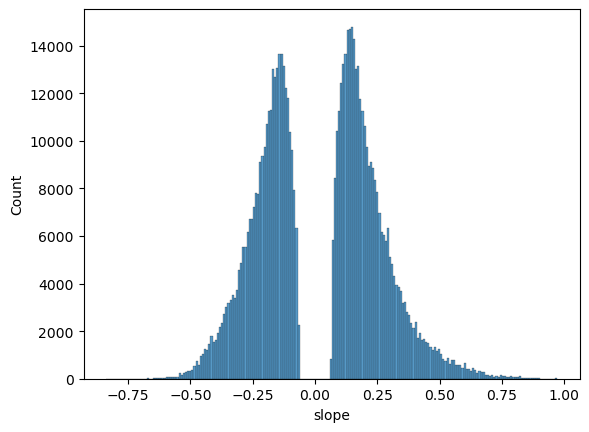

In [44]:
sns.histplot(results_sign['slope'])

In [30]:
results_sign.head()

1         2         4         5         6         9        10  \
3   0.047469  0.094093  0.121946  0.086651  0.086564  0.060885  0.180309   
4   0.047469  0.094093  0.121946  0.086651  0.086564  0.060885  0.180309   
7   0.046401  0.099640  0.132827  0.090910  0.090808  0.061310  0.203970   
10  0.813770  0.848086  0.860154  0.844152  0.844104  0.826706  0.877607   
11  0.076573  0.116110  0.136131  0.110412  0.110345  0.089071  0.173686   

          11        12        13  ...        57        60     slope  \
3   0.073363  0.065133  0.177237  ...  0.059132  0.152967  0.609557   
4   0.073363  0.065133  0.177237  ...  0.059132  0.152967  0.609557   
7   0.075509  0.066112  0.200195  ...  0.059340  0.170461  0.681997   
10  0.836047  0.830119  0.876856  ...  0.825216  0.870363  0.203323   
11  0.099762  0.092798  0.171813  ...  0.087504  0.156660  0.381846   

           pvalue  intercept  snp_id     id  chrom  pos  snp_origin_bio1  
3   6.334959e-154  -2.574848   1_395  1_395      1  395         0.525547  
4   6.334959e-154  -2.574848   1_396  1_396      1  396         0.525547  
7   7.904935e-196  -2.548294   1_465  1_465      1  465         0.593214  
10   1.965670e-38   1.616196   1_508  1_508      1  508         0.417036  
11   1.846893e-81  -2.224113   1_643  1_643      1  643         0.428329  

[5 rows x 39 columns]

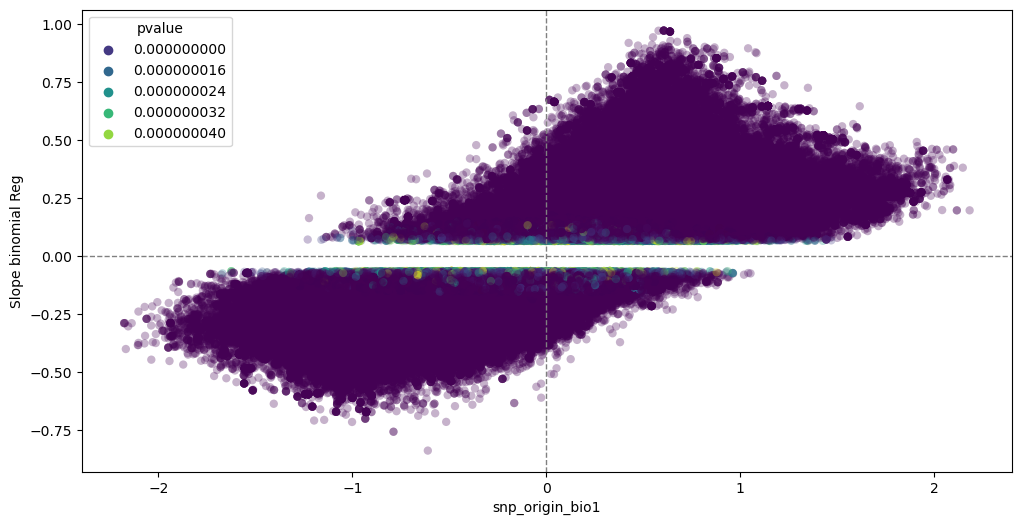

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming snp_origin_beta_binomial_reg is your DataFrame with SNP data

# Create a scatter plot using density for color
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(
    data=results_sign,
    x='snp_origin_bio1',
    y='slope',
    hue='pvalue',  # Use the density as color
    palette="viridis",  # Color mapping
    edgecolor="none",  # Remove white edge around the dots
    alpha=0.3,  # Set transparency
    ax=ax
)
ax.axhline(0, color='grey', linestyle='--', linewidth=1)
ax.axvline(0, color='grey', linestyle='--', linewidth=1)

# Add a color bar to show the density scale

plt.ylabel('Slope binomial Reg')
# Display the plot
#plt.savefig('snp_origin_across_space.png')

plt.show()


In [33]:
results_sign.columns

Index(['1', '2', '4', '5', '6', '9', '10', '11', '12', '13', '23', '24', '25',
       '26', '27', '28', '32', '33', '37', '42', '43', '45', '46', '48', '49',
       '52', '53', '54', '55', '57', '60', 'slope', 'pvalue', 'intercept',
       'snp_id', 'id', 'chrom', 'pos', 'snp_origin_bio1'],
      dtype='object')

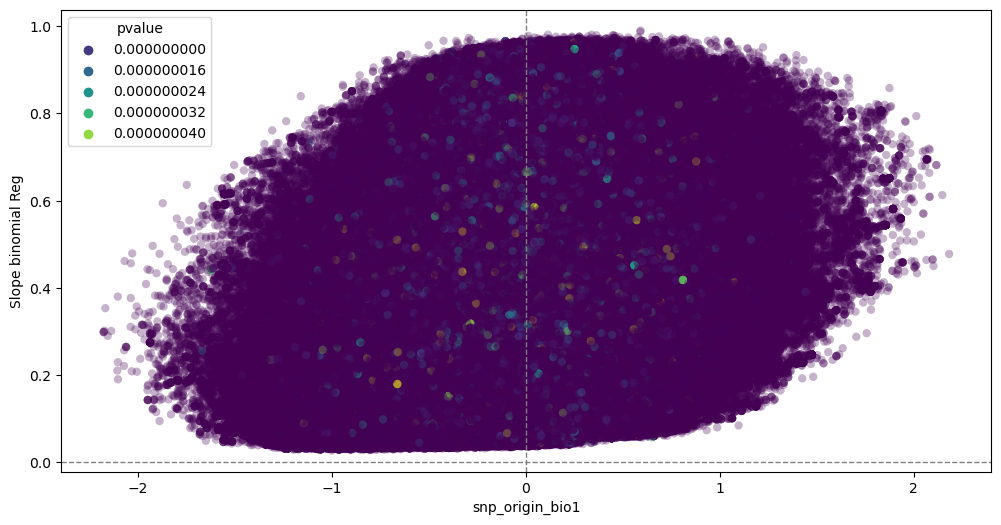

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming snp_origin_beta_binomial_reg is your DataFrame with SNP data

# Create a scatter plot using density for color
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(
    data=results_sign,
    x='snp_origin_bio1',
    y='2',
    hue='pvalue',  # Use the density as color
    palette="viridis",  # Color mapping
    edgecolor="none",  # Remove white edge around the dots
    alpha=0.3,  # Set transparency
    ax=ax
)
ax.axhline(0, color='grey', linestyle='--', linewidth=1)
ax.axvline(0, color='grey', linestyle='--', linewidth=1)

# Add a color bar to show the density scale

plt.ylabel('Slope binomial Reg')
# Display the plot
#plt.savefig('snp_origin_across_space.png')

plt.show()


In [39]:
results_sign_most = results_sign.sort_values('pvalue').head(10000)

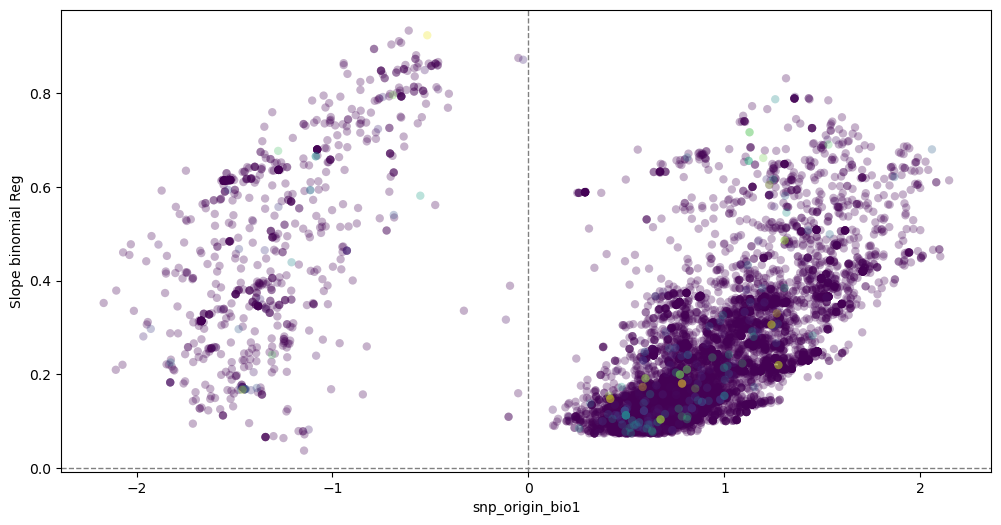

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming snp_origin_beta_binomial_reg is your DataFrame with SNP data

# Create a scatter plot using density for color
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(
    data=results_sign_most,
    x='snp_origin_bio1',
    y='45',
    hue='pvalue',  # Use the density as color
    palette="viridis",  # Color mapping
    edgecolor="none",  # Remove white edge around the dots
    alpha=0.3,  # Set transparency
    ax=ax,
    legend = False
)
ax.axhline(0, color='grey', linestyle='--', linewidth=1)
ax.axvline(0, color='grey', linestyle='--', linewidth=1)

# Add a color bar to show the density scale

plt.ylabel('Slope binomial Reg')
# Display the plot
#plt.savefig('snp_origin_across_space.png')

plt.show()


In [387]:
env_site_scaled = pd.read_csv('env_site_scaled.csv').drop_duplicates()

In [388]:
est = results_sign[['slope', 'pvalue', 'intercept']]

In [390]:
prob_success_all = {}
for site,env_value in zip(env_site_scaled['site'], env_site_scaled['env_scaled']):
    linear_predictor = env_value * est['slope'] + est['intercept']
    prob_success = 1 / (1 + np.exp(-linear_predictor))
    prob_success_all[site] = prob_success


In [399]:
prob_success_all = prob_success_all.reset_index(drop=True)

In [529]:
mask_full_genotype = snp_dict['id'].isin(results_sign['snp_id'])
genotype_counts_red = genotype_counts.loc[mask_full_genotype,:]
genotype_counts_red = genotype_counts_red.reset_index(drop=True)
genotype_counts_red = genotype_counts_red.replace({2: 1, 1: 0.5, 0: 0})

In [530]:
genotype_counts_red.shape

(661475, 231)

In [531]:
prob_success_1_site.shape

(661475,)

In [ ]:
111454048

In [539]:
unique_sites

array([ 1,  2,  4,  5,  6,  9, 10, 11, 12, 13, 23, 24, 25, 26, 27, 28, 32,
       33, 37, 42, 43, 45, 46, 48, 49, 52, 53, 54, 55, 57, 60])

In [540]:
mask_full_genotype = snp_dict['id'].isin(results_sign['snp_id'])
genotype_counts_red = genotype_counts.loc[mask_full_genotype,:]
genotype_counts_red = genotype_counts_red.reset_index(drop=True)
genotype_counts_red = genotype_counts_red.replace({2: 1, 1: 0.5, 0: 0})


go_per_site = {}
for site in unique_sites:
    if site != 33:
        print(site)
        prob_success_1_site = prob_success_all[site]
        genotype_counts_mul = genotype_counts_red.sub(prob_success_1_site, axis=0)   
        genotype_counts_mul = genotype_counts_mul**2
        ## sum over ecotypes 
        go = (genotype_counts_mul.sum(axis=0)) / len(genotype_counts_mul)
        go_per_site[site] = go

1
2
4
5
6
9
10
11
12
13
23
24
25
26
27
28
32
37
42
43
45
46
48
49
52
53
54
55
57
60


In [541]:
go_per_site_df = pd.DataFrame(go_per_site)

In [542]:
go_per_site_df.index = go_per_site_df.index.astype(int)

In [543]:
go_per_site_df.describe()

1           2           4           5           6           9   \
count  231.000000  231.000000  231.000000  231.000000  231.000000  231.000000   
mean     0.143511    0.144526    0.145645    0.144265    0.144262    0.143595   
std      0.015751    0.015782    0.016226    0.015694    0.015693    0.015585   
min      0.122780    0.121885    0.122038    0.121942    0.121943    0.122686   
25%      0.131556    0.132363    0.133531    0.132260    0.132254    0.131689   
50%      0.137826    0.139601    0.139509    0.139092    0.139083    0.138201   
75%      0.155085    0.153369    0.154986    0.152869    0.152861    0.153257   
max      0.196773    0.181500    0.181481    0.183354    0.183377    0.191237   

               10          11          12          13  ...          45  \
count  231.000000  231.000000  231.000000  231.000000  ...  231.000000   
mean     0.148412    0.143864    0.143671    0.148256  ...    0.144554   
std      0.017421    0.015590    0.015574    0.017354  ...    0.015792   
min      0.121093    0.122196    0.122485    0.121114  ...    0.121882   
25%      0.135768    0.131898    0.131661    0.135588  ...    0.132355   
50%      0.142404    0.138561    0.138228    0.142311  ...    0.139594   
75%      0.157824    0.153122    0.153332    0.157558  ...    0.153409   
max      0.190513    0.187082    0.189735    0.190076  ...    0.181315   

               46          48          49          52          53          54  \
count  231.000000  231.000000  231.000000  231.000000  231.000000  231.000000   
mean     0.143505    0.143841    0.143521    0.143542    0.143580    0.143590   
std      0.015680    0.016237    0.015634    0.015612    0.015591    0.015587   
min      0.122765    0.123195    0.122777    0.122796    0.122741    0.122705   
25%      0.131523    0.131975    0.131774    0.131719    0.131716    0.131698   
50%      0.137775    0.137943    0.137903    0.138046    0.138112    0.138170   
75%      0.155246    0.155148    0.154122    0.153548    0.153302    0.153273   
max      0.195066    0.204035    0.193649    0.192746    0.191615    0.191368   

               55          57          60  
count  231.000000  231.000000  231.000000  
mean     0.143513    0.143570    0.147063  
std      0.015649    0.015595    0.016836  
min      0.122770    0.122782    0.121413  
25%      0.131680    0.131737    0.134921  
50%      0.137828    0.138049    0.141026  
75%      0.154554    0.153334    0.155892  
max      0.194149    0.191886    0.186498  

[8 rows x 30 columns]

In [544]:
go_per_site_df

1         2         4         5         6         9         10  \
0    0.129388  0.128258  0.128659  0.128237  0.128237  0.128652  0.130448   
1    0.134682  0.133288  0.133502  0.133316  0.133316  0.133883  0.134882   
2    0.150195  0.157931  0.161642  0.156856  0.156843  0.152720  0.168453   
3    0.134409  0.131457  0.131028  0.131681  0.131684  0.133062  0.131361   
4    0.135963  0.132703  0.132161  0.132964  0.132968  0.134503  0.132329   
..        ...       ...       ...       ...       ...       ...       ...   
226  0.176140  0.166876  0.163580  0.167949  0.167962  0.172674  0.158894   
227  0.124449  0.127085  0.128987  0.126597  0.126591  0.125055  0.133155   
228  0.128839  0.127839  0.128192  0.127820  0.127820  0.128185  0.129765   
229  0.129095  0.132095  0.134100  0.131570  0.131563  0.129847  0.138376   
230  0.122780  0.123874  0.125128  0.123584  0.123580  0.122850  0.128229   

           11        12        13  ...        45        46        48  \
0    0.128336  0.128513  0.130333  ...  0.128263  0.129124  0.130855   
1    0.133496  0.133722  0.134788  ...  0.133288  0.134403  0.136185   
2    0.154816  0.153457  0.168115  ...  0.158041  0.150942  0.147315   
3    0.132251  0.132748  0.131316  ...  0.131437  0.133962  0.136604   
4    0.133608  0.134159  0.132291  ...  0.132680  0.135481  0.138302   
..        ...       ...       ...  ...       ...       ...       ...   
226  0.170151  0.171754  0.159090  ...  0.166770  0.175059  0.180855   
227  0.125763  0.125285  0.132932  ...  0.127136  0.124596  0.124203   
228  0.127906  0.128062  0.129663  ...  0.127843  0.128604  0.130155   
229  0.130655  0.130115  0.138149  ...  0.132150  0.129289  0.128636   
230  0.123139  0.122930  0.128055  ...  0.123905  0.122765  0.123195   

           49        52        53        54        55        57        60  
0    0.128930  0.128818  0.128691  0.128665  0.128996  0.128720  0.129495  
1    0.134193  0.134070  0.133928  0.133898  0.134264  0.133961  0.134121  
2    0.151583  0.152002  0.152538  0.152657  0.151355  0.152408  0.165377  
3    0.133613  0.133400  0.133144  0.133090  0.133734  0.133204  0.131054  
4    0.135103  0.134872  0.134593  0.134534  0.135234  0.134659  0.132090  
..        ...       ...       ...       ...       ...       ...       ...  
226  0.174170  0.173608  0.172907  0.172755  0.174483  0.173075  0.160814  
227  0.124744  0.124852  0.125001  0.125036  0.124689  0.124964  0.131182  
228  0.128431  0.128332  0.128219  0.128197  0.128490  0.128245  0.128927  
229  0.129475  0.129606  0.129784  0.129825  0.129407  0.129740  0.136364  
230  0.122777  0.122796  0.122834  0.122844  0.122770  0.122824  0.126719  

[231 rows x 30 columns]